In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
plt.rc('font', family = "Malgun Gothic")
plt.style.use('ggplot')

In [2]:
# 최적 클러스터 개수 k를 찾기 위한 함수 
def Elbow(X):
    SSE = []
    for i in range(1,11):
        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans.fit(X)
        SSE.append(kmeans.inertia_)
        
    plt.plot(range(1,11), SSE, marker='o')
    plt.xlabel("# of clusters")
    plt.ylabel("SSE") #오차제곱합
    plt.title("Elbow Method for Optimal k")
    plt.show()

In [3]:
def kmeans(train_data, n):
    X = train_data[train_data["SVC_INDUTY_CD_NM"] == n]
    X = X.drop(n, axis=1)
    ## 최적 클러스터 개수 k 결정
    Elbow(X.iloc[:,2:])
    k = int(input("클러스터 개수 k를 입력하세요 : "))
    ## kmeans 군집화
    model = KMeans(n_clusters = k, random_state=0)
    model.fit(X.iloc[:,2:])
    X["cluster"] = model.labels_
    ## 군집 결과 시각화 
    plt.figure(figsize=(10, 5))
    X["cluster"].astype(str).hist()
    plt.xlabel("군집")
    plt.ylabel("개수")
    plt.title(n + " 군집 결과")
    plt.show()
    print(n + " 군집별 블록 개수")
    print(X["cluster"].value_counts())
    return X # 클러스터링한 데이터 프레임 return

In [4]:
def clusterN(train_data, N):
    ## N번째 군집 데이터 프레임
    clusterN = train_data[train_data["cluster"] == N]
    print("군집 %d 업종의 개수 분포" %N)
    print(clusterN.mean(axis=0)[1:-1].describe()) # 업종의 업소의 평균 개수
    ## 시너지를 보고싶은 업종 리스트
    svc_list = []
    for svc, cnt in clusterN.mean(axis=0)[1:-1].items():
        if cnt >= 1: 
            svc_list.append(svc)
    ## 시너지를 보고싶은 업종만 있는 데이터 프레임
    clusterN = clusterN[["BLCK_CD"] + svc_list]
    display(clusterN)
    return clusterN, svc_list

In [5]:
def synergy_N(clusterN, svc_list):
    # clusterN는 군집별 데이터 프레임
    # svc_list는 다이나믹을 보고 싶은 업종 리스트
    temp = clusterN[["BLCK_CD"] + svc_list]
    temp.set_index("BLCK_CD", inplace=True)
    print("업종별 긍정적인 응집도 비율")
    for svc in svc_list:
        total_cnt = 0 # 업소의 개수
        good_cnt = 0  # 블록 매출액이 업종 매출액보다 큰 경우
        error_cnt = 0 # 매출액 정보가 없는 경우
        for blck in temp.index:
            if temp.loc[blck, svc] > 0:
                total_cnt += 1
                try:
                    if BLCK_SVC_AMT.loc[blck][svc] > SVC_AMT_N.loc[svc]:
                        good_cnt +=1  
                except TypeError:
                    error_cnt += 1
                except KeyError:
                    error_cnt += 1
        ## 긍정적인 응집도 비율
        if total_cnt == error_cnt: # 매출액 데이터가 하나도 없는 업종
            print(svc, 0) 
        else: # 긍정적인 응집도
            print(svc, round(good_cnt/(total_cnt-error_cnt)*100, 2))  

In [6]:
def synergy_B(clusterN, svc_list):
    # clusterN는 군집별 데이터 프레임
    # svc_list는 다이나믹을 보고 싶은 업종 리스트
    temp = clusterN[["BLCK_CD"] + svc_list]
    temp.set_index("BLCK_CD", inplace=True)
    print("업종별 긍정적인 응집도 비율")
    for svc in svc_list:
        total_cnt = 0 # 업소의 개수
        good_cnt = 0  # 블록 매출액이 업종 매출액보다 큰 경우
        error_cnt = 0 # 매출액 정보가 없는 경우
        for blck in temp.index:
            if temp.loc[blck, svc] > 0:
                total_cnt += 1
                try:
                    if BLCK_SVC_AMT.loc[blck][svc] > SVC_AMT_B.loc[svc]:
                        good_cnt +=1  
                except TypeError:
                    error_cnt += 1
                except KeyError:
                    error_cnt += 1
        ## 긍정적인 응집도 비율
        if total_cnt == error_cnt: # 매출액 데이터가 하나도 없는 업종
            print(svc, 0) 
            #L.append([svc,0])
        else: # 긍정적인 응집도
            print(svc, round(good_cnt/(total_cnt-error_cnt)*100, 2))  
            #dic[svc]=round(good_cnt/(total_cnt-error_cnt)*100, 2)
    #return dic

In [66]:
def synergy_check(df, q, cluster, size=(10,7)):
    #q =["한식음식점","노래방","호프-간이주점","커피-음료"]
    dic_1 = {}
    df1 = df.loc[cluster["BLCK_CD"].values]         #파워업종이 한식음식점인 블록
    df2 = df.drop(cluster["BLCK_CD"].values,axis=0) #파워업종이 한식음식점이 아닌 블록
    for k in q:
        dic_1[k] = (df1[df1["SVC_INDUTY_CD_NM"]==k].mean()["AMT"], df2[df2["SVC_INDUTY_CD_NM"]==k].mean()["AMT"])
    final_df = pd.DataFrame(dic_1).T
    final_df.columns = ["Power","Nonpower"]
    x = np.arange(len(q))
    plt.figure(figsize=size)
    plt.title(q[0]+"과 시너지 효과를 내는 업종")
    plt.bar(x-0.0,final_df["Power"],width=0.2,label="파워업종")
    plt.bar(x+0.2,final_df["Nonpower"],width=0.2,label='파워업종X')
    plt.xticks(x,q,rotation=45)
    plt.legend()
    plt.xlabel("업종")
    plt.ylabel("평균매출액")
    plt.show()

# 1. 데이터 불러오기

In [8]:
gangnam = pd.read_csv("nam_good_df.csv",encoding='utf-8-sig')
gangnam

,BLCK_CD,SVC_INDUTY_CD_NM,RATIO_SCORE,count
0,3578,편의점,2.120220,122
1,18080,편의점,0.946068,122
2,23054,편의점,2.011199,122
3,26949,편의점,3.160230,122
4,27271,편의점,3.019498,122
...,...,...,...,...
1924,279881,노래방,1.301353,13
1925,349747,노래방,1.236932,13
1926,353305,노래방,1.793231,13
1927,353368,노래방,1.509783,13


In [9]:
gangbuk = pd.read_csv("buk_good_df.csv",encoding='utf-8-sig')
gangbuk

,BLCK_CD,SVC_INDUTY_CD_NM,RATIO_SCORE,count
0,169513,한식음식점,3.102969,135
1,213447,한식음식점,2.643528,135
2,213458,한식음식점,3.272755,135
3,213460,한식음식점,3.929401,135
4,213464,한식음식점,1.365214,135
...,...,...,...,...
468,220516,한의원,2.926953,10
469,220551,한의원,1.965905,10
470,220846,한의원,2.236375,10
471,221165,한의원,1.663684,10


## 1.1 블록별 업종별 업소 개수

In [10]:
SVC = pd.read_csv("C:/Users/bigdata10/Desktop/데이터/SVC_INDUTY_MAPNG_NEW.csv",sep="|") # 업종매핑 테이블
SVC.head()

,SVC_INDUTY_CD,SVC_INDUTY_CD_NM,INDUTY_CD,INDUTY_CD_NM
0,CS100001,한식음식점,56111,한식 음식점업
1,CS100002,중식음식점,56112,중식 음식점업
2,CS100003,일식음식점,56113,일식 음식점업
3,CS100004,양식음식점,56114,서양식 음식점업
4,CS100004,양식음식점,56119,기타 외국식 음식점업


In [11]:
SVC_CODE = SVC["SVC_INDUTY_CD_NM"].unique()
SVC_CODE # 100개의 업종

array(['한식음식점', '중식음식점', '일식음식점', '양식음식점', '제과점', '패스트푸드점', '치킨전문점',
       '분식전문점', '호프-간이주점', '커피-음료', '일반교습학원', '외국어학원', '예술학원', '컴퓨터학원',
       '스포츠 강습', '일반의원', '치과의원', '한의원', '동물병원', '변호사사무소', '변리사사무소',
       '법무사사무소', '기타법무서비스', '회계사사무소', '세무사사무소', '당구장', '골프연습장', '볼링장',
       'PC방', '전자게임장', '기타오락장', '복권방', '통신기기수리', '스포츠클럽', '자동차수리',
       '자동차미용', '모터사이클수리', '미용실', '네일숍', '피부관리실', '세탁소', '가전제품수리',
       '부동산중개업', '여관', '게스트하우스', '고시원', '노래방', '독서실', 'DVD방', '녹음실',
       '사진관', '통번역서비스', '건축물청소', '여행사', '비디오/서적임대', '의류임대', '가정용품임대',
       '슈퍼마켓', '편의점', '컴퓨터및주변장치판매', '핸드폰', '주류도매', '미곡판매', '육류판매',
       '수산물판매', '청과상', '반찬가게', '일반의류', '한복점', '유아의류', '신발', '가방', '안경',
       '시계및귀금속', '의약품', '의료기기', '서적', '문구', '화장품', '미용재료', '운동/경기용품',
       '자전거 및 기타운송장비', '완구', '섬유제품', '화초', '애완동물', '중고가구', '가구', '가전제품',
       '철물점', '악기', '인테리어', '조명용품', '중고차판매', '자동차부품', '모터사이클및부품',
       '재생용품 판매점', '예술품', '주유소', '전자상거래업'], dtype=object)

In [12]:
CNFM_FINAL = pd.read_csv("CNFM_FINAL.csv") # 업소정보 테이블 (unique)
CNFM_FINAL.head()

,STDR_YM_CD,STOR_INNB,STOR_NM,SVC_INDUTY_CD,OPBIZ_YM,CLSBIZ_YM,OLD_ADRES,NW_ADRES,TELNO,BLCK_CD,HOUS_ID,PROC_CLSS,DW_REGIST_DT,ROAD_CD,XCNTS_VALUE,YDNTS_VALUE,FRC_YN,STD_INDCLS_INDUTY_CD,BIZ_MNTH
0,201906,1004015113,한***,NaN,2007-04-01,2019-12-31,NaN,NaN,02)904-6694,219851,390002,NaN,17-SEP-19,NaN,201935.0,460279.0,N,28423,153
1,201906,1003767731,사********,NaN,2010-07-01,2019-12-31,NaN,NaN,02)518-1779,132329,1090000,NaN,17-SEP-19,NaN,203387.0,446580.0,N,46433,114
2,201906,1003768050,동*****,NaN,2010-03-01,2019-12-31,NaN,NaN,NaN,30757,0,NaN,17-SEP-19,NaN,202741.0,446136.0,N,75120,118
3,201906,1004582176,대*****,NaN,2014-06-01,2019-12-31,NaN,NaN,02)552-6696,350525,1130004,NaN,17-SEP-19,NaN,204129.0,445699.0,N,45219,67
4,201906,1003262158,보*****,NaN,2014-08-01,2019-12-31,NaN,NaN,02)6010-1004,30542,1870016,NaN,17-SEP-19,NaN,202428.0,445248.0,N,96991,65


In [13]:
BLCK_SVC = pd.merge(CNFM_FINAL,SVC,left_on ="STD_INDCLS_INDUTY_CD",right_on="INDUTY_CD")
BLCK_SVC_CNT = BLCK_SVC.groupby(["BLCK_CD","SVC_INDUTY_CD_NM"])["SVC_INDUTY_CD_NM"].count().unstack()
BLCK_SVC_CNT = BLCK_SVC_CNT.fillna(0)
BLCK_SVC_CNT.reset_index(inplace=True)
BLCK_SVC_CNT # 블록별 업종별 업소 개수 

SVC_INDUTY_CD_NM,BLCK_CD,DVD방,PC방,가구,가방,가전제품,가전제품수리,가정용품임대,건축물청소,게스트하우스,...,편의점,피부관리실,한복점,한식음식점,한의원,핸드폰,호프-간이주점,화장품,화초,회계사사무소
0,118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4338,502557,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4339,502558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4340,502597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4341,502807,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0


## 1.2 블록별 업종별 평균 매출액

In [14]:
SELNG = pd.read_csv("C:/Users/bigdata10/Desktop/데이터/SELNG.csv",sep="|") # 매출금액
SELNG.head()

,BLCK_CD,TA_YM,KSIC_CD,MCT_CNT,AMT,CNT,MIN_AMT,MIN_CNT,MAX_AMT,MAX_CNT,...,RCNT_60,MCT_SALES,NEW_MCT,P1_M6,P1_1Y,P1_2Y,P1_3Y,P1_4Y,P1_5Y,P1_6Y
0,10019,201701,47413,1,5000000,1,5000000,1,5000000,1,...,0,25,0,0,0,0,1,0,0,0
1,10019,201701,47416,1,20158000,15,20158000,15,20158000,15,...,1,130,0,0,0,0,0,0,0,1
2,10019,201701,47420,1,1429000,3,1429000,3,1429000,3,...,0,19,0,0,0,1,0,0,0,0
3,10019,201701,47811,1,12668290,706,12668290,706,12668290,706,...,33,101,0,0,0,0,0,0,0,1
4,10019,201701,47813,1,4000000,1,4000000,1,4000000,1,...,0,13,0,0,0,1,0,0,0,0


In [15]:
SELNG_DEC = SELNG[SELNG["TA_YM"] == 201912] # 2019년 12월 매출액만 가져오기
SELNG_DEC_SVC = SELNG_DEC.merge(SVC, left_on="KSIC_CD", right_on="INDUTY_CD")

In [16]:
BLCK_SVC_AMT = SELNG_DEC_SVC.groupby(["BLCK_CD","SVC_INDUTY_CD_NM"])["AMT"].mean()
BLCK_SVC_AMT # 블록별 업종별 평균 매출액

BLCK_CD  SVC_INDUTY_CD_NM
118      노래방                   1821000.0
         커피-음료                 1002400.0
         편의점                   6860940.0
         한식음식점                 1421000.0
         호프-간이주점               1145900.0
                                ...     
502813   편의점                 107179269.0
         피부관리실                  612000.0
         한식음식점                 2346600.0
         한의원                   1567200.0
         화초                     625000.0
Name: AMT, Length: 21425, dtype: float64

In [17]:
SIGNGU = pd.read_csv("C:/Users/bigdata10/Desktop/데이터/SIGNGU_DIM.csv",sep="|") # 시군구정보
BLCK_DIM = pd.read_csv("C:/Users/bigdata10/Desktop/데이터/BLCK_DIM.csv",sep="|") # 블록영역정보
SIGNGU_CD_DF = pd.merge(SIGNGU,BLCK_DIM,on="SIGNGU_CD")
GANGBUK_CD = BLCK_DIM[BLCK_DIM["SIGNGU_CD"]==11305].iloc[:,[0]] #2419

In [18]:
GANGNAM_CD = BLCK_DIM[BLCK_DIM["SIGNGU_CD"]==11680].iloc[:,[0]]

In [20]:
SVC_AMT_N = pd.merge(SELNG_DEC_SVC,GANGNAM_CD,on="BLCK_CD").groupby("SVC_INDUTY_CD_NM").mean()["AMT"] # 강남구 업종별 평균 매출액
SVC_AMT_B = pd.merge(SELNG_DEC_SVC,GANGBUK_CD,on="BLCK_CD").groupby("SVC_INDUTY_CD_NM").mean()["AMT"] # 강북구 업종별 평균 매출액

# 1. 강남구 군집화

## 1.1 데이터 전처리

In [21]:
gangnam_train = gangnam[["BLCK_CD","SVC_INDUTY_CD_NM"]]
gangnam_train

,BLCK_CD,SVC_INDUTY_CD_NM
0,3578,편의점
1,18080,편의점
2,23054,편의점
3,26949,편의점
4,27271,편의점
...,...,...
1924,279881,노래방
1925,349747,노래방
1926,353305,노래방
1927,353368,노래방


In [22]:
gangnam_train = gangnam_train.merge(BLCK_SVC_CNT, how="left", left_on="BLCK_CD", right_on="BLCK_CD")
gangnam_train

,BLCK_CD,SVC_INDUTY_CD_NM,DVD방,PC방,가구,가방,가전제품,가전제품수리,가정용품임대,건축물청소,...,편의점,피부관리실,한복점,한식음식점,한의원,핸드폰,호프-간이주점,화장품,화초,회계사사무소
0,3578,편의점,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,18080,편의점,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2,23054,편의점,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,26949,편의점,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,2.0,5.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0
4,27271,편의점,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,4.0,0.0,1.0,2.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924,279881,노래방,2.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,14.0,0.0,0.0,5.0,0.0,0.0,0.0
1925,349747,노래방,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,5.0,0.0,4.0,0.0,0.0,2.0,3.0,2.0,0.0
1926,353305,노래방,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,8.0,0.0,0.0,2.0,0.0,0.0,0.0
1927,353368,노래방,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,7.0,0.0,0.0,2.0,0.0,0.0,0.0


In [23]:
# 군집화의 성능 향상을 위해, 컬럼별로 0의 비율 구한 뒤 제거하기
ZERO_RATIO = gangnam_train.isin([0]).sum()/len(gangnam_train)*100
ZERO_RATIO = ZERO_RATIO[2:]
ZERO_RATIO

DVD방       96.371177
PC방        89.009850
가구         80.611716
가방         86.780715
가전제품       85.692068
             ...    
핸드폰        83.411094
호프-간이주점    58.942457
화장품        32.555728
화초         67.703473
회계사사무소     86.936236
Length: 100, dtype: float64

In [24]:
# 강남구 100개의 업종 중에서 0의 비율이 90% 이상인 업종 제거
idx_cnt = 0   # 비율 90% 이상인 업종의 개수
idx_list = [] # 비율 90% 미만인 업종의 이름

for idx, ratio in ZERO_RATIO.items():
    if ratio >= 90: # 비율 90% 이상인 업종
        print(idx)
        idx_list.append(idx)
        idx_cnt += 1 
idx_cnt # 36개 업종

DVD방
가전제품수리
가정용품임대
건축물청소
게스트하우스
고시원
기타법무서비스
기타오락장
녹음실
동물병원
모터사이클및부품
모터사이클수리
미곡판매
미용재료
복권방
볼링장
비디오/서적임대
수산물판매
악기
여관
완구
유아의류
의류임대
자동차미용
자전거 및 기타운송장비
재생용품 판매점
전자게임장
주류도매
주유소
중고가구
중고차판매
청과상
컴퓨터학원
통번역서비스
통신기기수리
한복점


36

In [25]:
for idx in idx_list:
    gangnam_train.drop(idx, axis=1, inplace=True) # 36개 해당하는 업종 제거
gangnam_train # 1929 * 66

,BLCK_CD,SVC_INDUTY_CD_NM,PC방,가구,가방,가전제품,골프연습장,네일숍,노래방,당구장,...,패스트푸드점,편의점,피부관리실,한식음식점,한의원,핸드폰,호프-간이주점,화장품,화초,회계사사무소
0,3578,편의점,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,18080,편의점,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2,23054,편의점,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,26949,편의점,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,2.0,5.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0
4,27271,편의점,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,4.0,0.0,1.0,2.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924,279881,노래방,4.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,...,1.0,0.0,0.0,14.0,0.0,0.0,5.0,0.0,0.0,0.0
1925,349747,노래방,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,5.0,4.0,0.0,0.0,2.0,3.0,2.0,0.0
1926,353305,노래방,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,1.0,0.0,8.0,0.0,0.0,2.0,0.0,0.0,0.0
1927,353368,노래방,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,1.0,1.0,7.0,0.0,0.0,2.0,0.0,0.0,0.0


In [26]:
gangnam_train["SVC_INDUTY_CD_NM"].value_counts().describe()

count     42.000000
mean      45.928571
std       68.755627
min       10.000000
25%       13.250000
50%       23.000000
75%       55.750000
max      425.000000
Name: SVC_INDUTY_CD_NM, dtype: float64

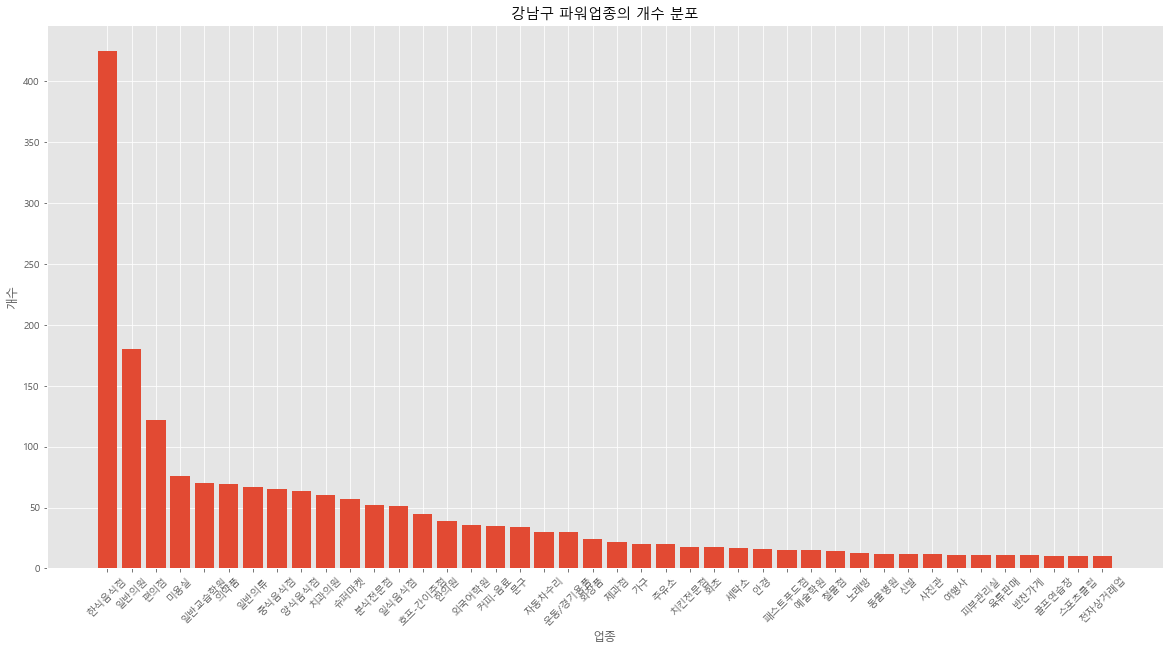

In [26]:
X = gangnam_train["SVC_INDUTY_CD_NM"].value_counts().index
Y = gangnam_train["SVC_INDUTY_CD_NM"].value_counts().values
plt.figure(figsize=(20, 10))
plt.bar(X,Y)
plt.xticks(rotation=45)
plt.xlabel("업종")
plt.ylabel("개수")
plt.title("강남구 파워업종의 개수 분포")
plt.show()

## 1.2 업종별 kmeans

In [27]:
GANGNAM_AMT_2 = pd.merge(SELNG_DEC_SVC,GANGNAM_CD,on="BLCK_CD").iloc[:,[0,1,2,4,-3]]
GANGNAM_AMT_2.set_index("BLCK_CD", inplace=True)
GANGNAM_AMT_2

,TA_YM,KSIC_CD,AMT,SVC_INDUTY_CD_NM
BLCK_CD,,,,
10019,201912,47122,6982960,편의점
10019,201912,47416,21849000,일반의류
10019,201912,47520,10320850,가구
10019,201912,47811,15851750,의약품
10019,201912,56111,24710000,한식음식점
...,...,...,...,...
272378,201912,47412,470000,한복점
267112,201912,73303,264000,사진관
420746,201912,47712,254790490,주유소


### 1) 강남구 편의점

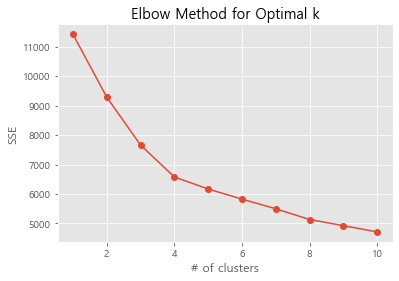

클러스터 개수 k를 입력하세요 : 4


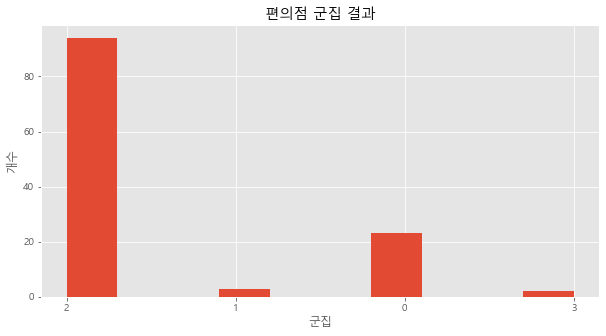

편의점 군집별 블록 개수
2    94
0    23
1     3
3     2
Name: cluster, dtype: int64


In [84]:
X1 = kmeans(gangnam_train, "편의점")

In [85]:
## 강남구 편의점 2번 군집
cluster2, svc_list = clusterN(X1,2)
synergy_N(cluster2, svc_list)

군집 2 업종의 개수 분포
count    63.000000
mean      0.361533
std       0.397652
min       0.031915
25%       0.111702
50%       0.212766
75%       0.430851
max       1.765957
dtype: float64


,BLCK_CD,부동산중개업,분식전문점,일반의류,커피-음료,한식음식점,화장품
0,3578,0.0,2.0,0.0,2.0,0.0,0.0
1,18080,1.0,1.0,1.0,0.0,3.0,0.0
2,23054,1.0,0.0,2.0,0.0,0.0,0.0
3,26949,1.0,3.0,7.0,6.0,1.0,2.0
4,27271,0.0,0.0,4.0,2.0,4.0,2.0
...,...,...,...,...,...,...,...
111,356754,2.0,1.0,0.0,0.0,4.0,0.0
114,358903,1.0,1.0,0.0,1.0,2.0,3.0
116,359063,5.0,4.0,0.0,2.0,3.0,1.0
117,359065,1.0,0.0,1.0,1.0,0.0,1.0


업종별 긍정적인 응집도 비율
부동산중개업 100.0
분식전문점 17.5
일반의류 12.9
커피-음료 22.81
한식음식점 12.28
화장품 11.11


In [86]:
## 강남구 편의점 0번 군집
cluster0, svc_list = clusterN(X1,0)
synergy_N(cluster0, svc_list)

군집 0 업종의 개수 분포
count    63.000000
mean      0.761905
std       1.428625
min       0.000000
25%       0.173913
50%       0.391304
75%       0.869565
max      10.695652
dtype: float64


,BLCK_CD,미용실,부동산중개업,분식전문점,세무사사무소,양식음식점,일반의류,일반의원,일식음식점,치킨전문점,커피-음료,피부관리실,한식음식점,호프-간이주점,화장품
34,271723,0.0,2.0,3.0,0.0,1.0,1.0,0.0,0.0,2.0,2.0,1.0,11.0,1.0,8.0
45,281004,2.0,3.0,5.0,0.0,2.0,1.0,1.0,1.0,1.0,4.0,0.0,15.0,2.0,3.0
53,356726,3.0,2.0,0.0,2.0,0.0,2.0,0.0,0.0,3.0,4.0,0.0,8.0,1.0,2.0
54,357349,4.0,5.0,8.0,1.0,2.0,2.0,0.0,2.0,2.0,3.0,1.0,7.0,0.0,3.0
67,16214,1.0,2.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,2.0,10.0,0.0,4.0
69,19490,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0,2.0
79,27914,0.0,2.0,2.0,0.0,0.0,0.0,2.0,1.0,3.0,2.0,0.0,10.0,1.0,1.0
89,176477,1.0,2.0,0.0,1.0,1.0,2.0,0.0,2.0,1.0,1.0,3.0,17.0,4.0,4.0
92,265840,1.0,1.0,2.0,0.0,5.0,0.0,0.0,5.0,1.0,5.0,2.0,16.0,4.0,0.0
94,267467,0.0,3.0,3.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,8.0,1.0,0.0


업종별 긍정적인 응집도 비율
미용실 7.14
부동산중개업 0
분식전문점 13.33
세무사사무소 0
양식음식점 0.0
일반의류 0.0
일반의원 0.0
일식음식점 20.0
치킨전문점 50.0
커피-음료 27.78
피부관리실 42.86
한식음식점 47.83
호프-간이주점 10.0
화장품 0.0


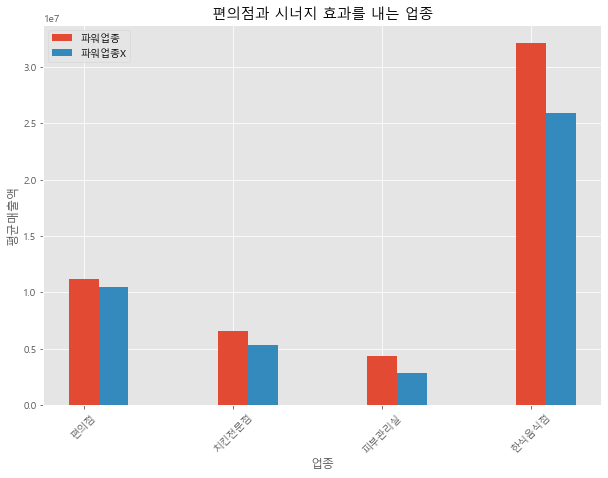

In [87]:
synergy_check(GANGNAM_AMT_2,["편의점","치킨전문점","피부관리실","한식음식점"],cluster0)

In [88]:
cluster0['BLCK_CD'].values

array([271723, 281004, 356726, 357349,  16214,  19490,  27914, 176477,
       265840, 267467, 267485, 272984, 274613, 275243, 353371, 354720,
       355774, 358312, 358634, 359000, 359326, 360699, 422440],
      dtype=int64)

temp = BLCK_DIM.loc[cluster0.index].iloc[:,[0,3,4,5,6,7,8]]
temp.to_csv("C:/Users/bigdata10/Desktop/데이터/블록내 업종간 다이나믹 분석/시각화 데이터/gangnam1_0.csv")

### 2) 강남구 미용실

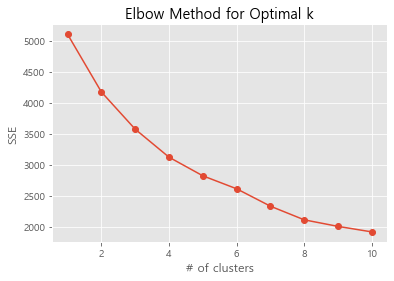

클러스터 개수 k를 입력하세요 : 4


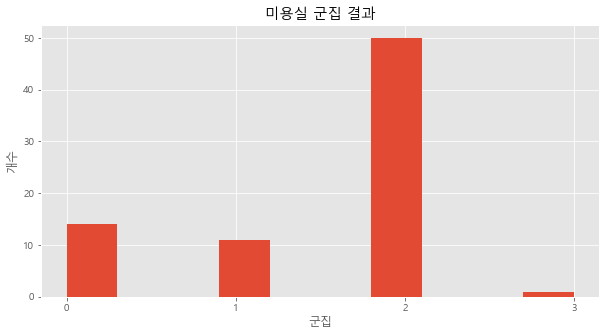

미용실 군집별 블록 개수
2    50
0    14
1    11
3     1
Name: cluster, dtype: int64


In [89]:
X2 = kmeans(gangnam_train, "미용실")

In [90]:
## 강남구 미용실 2번 군집
cluster2, svc_list = clusterN(X2,2)
synergy_N(cluster2, svc_list)

군집 2 업종의 개수 분포
count    63.000000
mean      0.303175
std       0.344659
min       0.000000
25%       0.060000
50%       0.180000
75%       0.430000
max       1.500000
dtype: float64


,BLCK_CD,부동산중개업,일반의류,한식음식점
1374,24434,0.0,1.0,3.0
1375,28225,1.0,2.0,0.0
1379,32939,0.0,2.0,1.0
1382,33657,0.0,3.0,2.0
1383,268862,0.0,2.0,0.0
1384,269096,0.0,1.0,0.0
1385,269170,0.0,2.0,0.0
1386,269615,0.0,2.0,0.0
1387,273081,5.0,0.0,2.0
1388,275113,1.0,2.0,2.0


업종별 긍정적인 응집도 비율
부동산중개업 100.0
일반의류 3.85
한식음식점 4.17


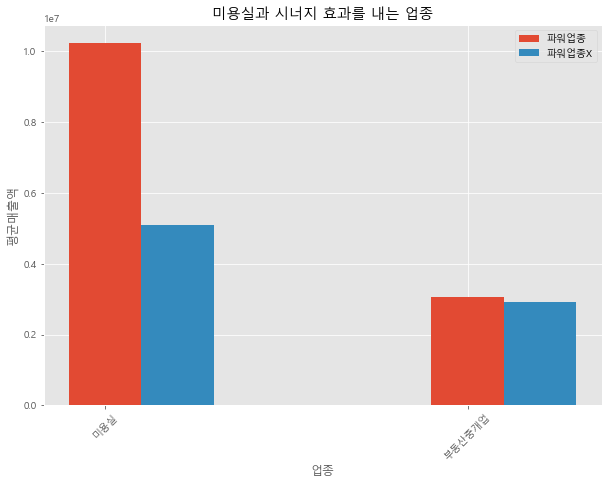

In [91]:
synergy_check(GANGNAM_AMT_2,["미용실","부동산중개업"],cluster2)

In [92]:
cluster2['BLCK_CD'].values

array([ 24434,  28225,  32939,  33657, 268862, 269096, 269170, 269615,
       273081, 275113, 275731, 358280, 358754, 362355, 416854,  24432,
        24454,  28415,  28550,  29886,  30542,  30781,  31010,  31225,
        31433,  31982,  32010,  32015,  32389,  32431,  33195,  35690,
       148970, 190043, 264864, 264905, 267620, 268941, 269025, 275004,
       275037, 275418, 278658, 278968, 349527, 353377, 359917, 416920,
       421780, 501906], dtype=int64)

temp = BLCK_DIM.loc[cluster2.index].iloc[:,[0,3,4,5,6,7,8]]
temp.to_csv("C:/Users/bigdata10/Desktop/데이터/블록내 업종간 다이나믹 분석/시각화 데이터/gangnam2_2.csv")

In [93]:
## 강남구 미용실 0번 군집
cluster0, svc_list = clusterN(X2,0)
synergy_N(cluster0, svc_list)

군집 0 업종의 개수 분포
count    63.000000
mean      0.615646
std       1.303602
min       0.000000
25%       0.071429
50%       0.142857
75%       0.678571
max       9.428571
dtype: float64


,BLCK_CD,분식전문점,사진관,시계및귀금속,양식음식점,일반의류,일반의원,커피-음료,피부관리실,한식음식점,호프-간이주점,화장품
1372,24426,1.0,1.0,3.0,0.0,6.0,2.0,2.0,1.0,0.0,1.0,3.0
1376,28416,1.0,1.0,1.0,0.0,13.0,0.0,2.0,1.0,1.0,1.0,0.0
1377,28742,0.0,0.0,0.0,2.0,17.0,0.0,5.0,0.0,0.0,2.0,9.0
1378,32531,2.0,0.0,0.0,2.0,8.0,0.0,2.0,1.0,6.0,3.0,2.0
1380,33154,3.0,8.0,0.0,6.0,17.0,4.0,2.0,3.0,4.0,0.0,2.0
1381,33564,1.0,2.0,2.0,1.0,5.0,3.0,3.0,3.0,0.0,0.0,3.0
1394,502205,4.0,2.0,2.0,1.0,9.0,2.0,1.0,4.0,3.0,1.0,2.0
1397,24441,3.0,1.0,2.0,0.0,8.0,1.0,1.0,0.0,7.0,0.0,1.0
1401,28374,0.0,9.0,1.0,3.0,11.0,2.0,5.0,1.0,6.0,1.0,5.0
1417,32718,0.0,0.0,0.0,1.0,6.0,1.0,1.0,0.0,5.0,0.0,0.0


업종별 긍정적인 응집도 비율
분식전문점 55.56
사진관 25.0
시계및귀금속 0.0
양식음식점 28.57
일반의류 23.08
일반의원 0.0
커피-음료 27.27
피부관리실 37.5
한식음식점 33.33
호프-간이주점 33.33
화장품 0.0


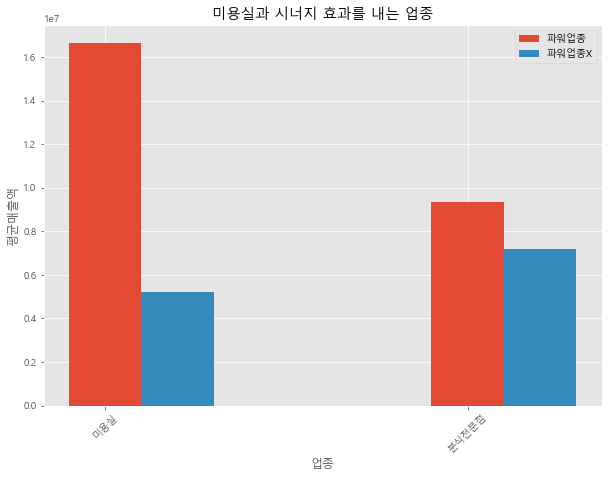

In [94]:
synergy_check(GANGNAM_AMT_2,["미용실","분식전문점"],cluster0)

In [95]:
cluster0['BLCK_CD'].values

array([ 24426,  28416,  28742,  32531,  33154,  33564, 502205,  24441,
        28374,  32718,  32808,  33633,  33666,  33672], dtype=int64)

temp = BLCK_DIM.loc[cluster0.index].iloc[:,[0,3,4,5,6,7,8]]
temp.to_csv("C:/Users/bigdata10/Desktop/데이터/블록내 업종간 다이나믹 분석/시각화 데이터/gangnam2_0.csv")

In [96]:
## 강남구 미용실 1번 군집
cluster1, svc_list = clusterN(X2,1)
synergy_N(cluster1, svc_list)

군집 1 업종의 개수 분포
count    63.000000
mean      0.662338
std       1.070362
min       0.000000
25%       0.090909
50%       0.272727
75%       0.727273
max       5.727273
dtype: float64


,BLCK_CD,부동산중개업,분식전문점,양식음식점,예술학원,일반의류,일반의원,일식음식점,치과의원,커피-음료,패스트푸드점,피부관리실,한식음식점,화장품
1373,24427,0.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,4.0,0.0,2.0,9.0,2.0
1395,21716,0.0,0.0,1.0,3.0,1.0,4.0,0.0,3.0,0.0,2.0,2.0,6.0,2.0
1399,27731,2.0,1.0,0.0,0.0,1.0,12.0,0.0,4.0,4.0,0.0,1.0,0.0,3.0
1400,28217,0.0,4.0,2.0,2.0,4.0,7.0,2.0,0.0,1.0,0.0,1.0,4.0,2.0
1405,28726,2.0,1.0,1.0,1.0,4.0,7.0,2.0,2.0,2.0,4.0,0.0,5.0,4.0
1423,33681,0.0,1.0,2.0,0.0,5.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0
1432,269181,0.0,3.0,2.0,0.0,3.0,13.0,1.0,0.0,1.0,0.0,0.0,3.0,5.0
1433,273386,12.0,7.0,0.0,5.0,1.0,2.0,3.0,1.0,3.0,2.0,2.0,6.0,3.0
1441,357596,1.0,1.0,2.0,0.0,3.0,0.0,3.0,0.0,2.0,3.0,0.0,10.0,3.0
1442,357892,2.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,0.0,0.0,12.0,0.0


업종별 긍정적인 응집도 비율
부동산중개업 0
분식전문점 28.57
양식음식점 50.0
예술학원 33.33
일반의류 0.0
일반의원 44.44
일식음식점 50.0
치과의원 16.67
커피-음료 25.0
패스트푸드점 25.0
피부관리실 25.0
한식음식점 44.44
화장품 28.57


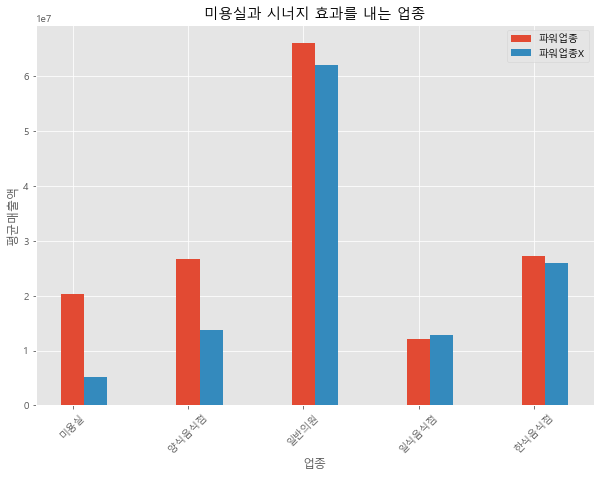

In [97]:
synergy_check(GANGNAM_AMT_2,["미용실","양식음식점","일반의원","일식음식점","한식음식점"],cluster1)

In [98]:
cluster1['BLCK_CD'].values

array([ 24427,  21716,  27731,  28217,  28726,  33681, 269181, 273386,
       357596, 357892, 417990], dtype=int64)

temp = BLCK_DIM.loc[cluster1.index].iloc[:,[0,3,4,5,6,7,8]]
temp.to_csv("C:/Users/bigdata10/Desktop/데이터/블록내 업종간 다이나믹 분석/시각화 데이터/gangnam2_1.csv")

### 3) 강남구 일반교습학원

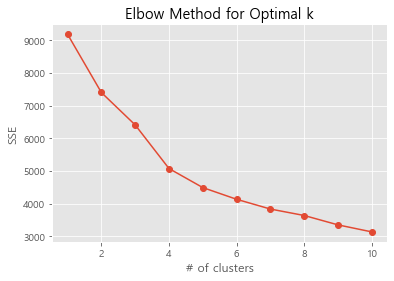

클러스터 개수 k를 입력하세요 : 4


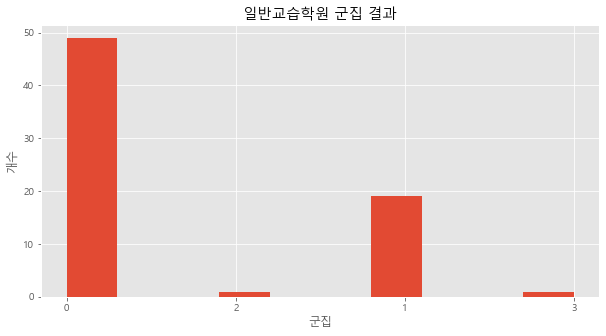

일반교습학원 군집별 블록 개수
0    49
1    19
3     1
2     1
Name: cluster, dtype: int64


In [92]:
X3 = kmeans(gangnam_train, "일반교습학원")

In [93]:
## 강남구 일반교습학원 0번 군집
cluster0, svc_list = clusterN(X3,0)
synergy_N(cluster0, svc_list)

군집 0 업종의 개수 분포
count    63.000000
mean      0.379981
std       0.426016
min       0.020408
25%       0.132653
50%       0.265306
75%       0.387755
max       2.387755
dtype: float64


,BLCK_CD,부동산중개업,외국어학원,일반의류,커피-음료,한식음식점
1152,22081,0.0,0.0,0.0,1.0,1.0
1153,24429,0.0,1.0,0.0,0.0,2.0
1154,24443,0.0,1.0,4.0,1.0,0.0
1155,30615,0.0,0.0,4.0,4.0,0.0
1157,33556,1.0,1.0,0.0,2.0,1.0
1158,33588,0.0,7.0,3.0,3.0,0.0
1159,198235,0.0,0.0,0.0,3.0,0.0
1160,264945,1.0,4.0,1.0,1.0,6.0
1161,265074,1.0,1.0,1.0,0.0,1.0
1163,265599,0.0,0.0,0.0,0.0,0.0


업종별 긍정적인 응집도 비율
부동산중개업 0
외국어학원 21.21
일반의류 8.33
커피-음료 20.83
한식음식점 7.14


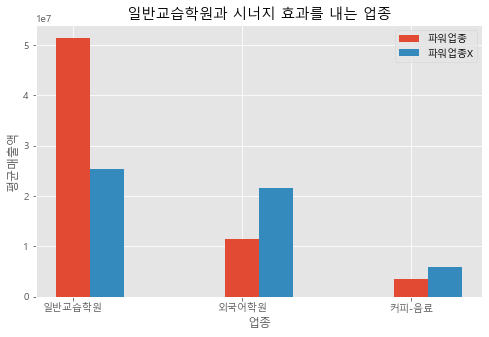

In [94]:
synergy_check(GANGNAM_AMT_2,["일반교습학원","외국어학원","커피-음료"],cluster0)

In [111]:
## 강남구 일반교습학원 1번 군집
cluster1, svc_list = clusterN(X3,1)
synergy_N(cluster1, svc_list)

군집 1 업종의 개수 분포
count    63.000000
mean      1.016708
std       1.400525
min       0.000000
25%       0.263158
50%       0.526316
75%       1.184211
max       8.052632
dtype: float64


,BLCK_CD,미용실,부동산중개업,분식전문점,세무사사무소,양식음식점,예술학원,외국어학원,의약품,일반의류,일반의원,일식음식점,제과점,치과의원,커피-음료,편의점,피부관리실,한식음식점,한의원,화장품
1162,265454,5.0,5.0,2.0,0.0,1.0,3.0,11.0,0.0,2.0,0.0,2.0,0.0,0.0,4.0,1.0,1.0,1.0,0.0,1.0
1165,268365,5.0,6.0,4.0,0.0,0.0,5.0,1.0,0.0,12.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0,6.0,1.0,9.0
1168,271820,2.0,2.0,4.0,0.0,0.0,0.0,11.0,3.0,2.0,2.0,1.0,3.0,4.0,1.0,1.0,1.0,5.0,2.0,1.0
1169,271836,3.0,1.0,5.0,0.0,4.0,4.0,10.0,2.0,0.0,5.0,1.0,0.0,0.0,1.0,0.0,0.0,6.0,2.0,0.0
1172,271854,5.0,0.0,2.0,0.0,0.0,0.0,13.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,4.0,1.0,0.0
1173,272423,0.0,2.0,0.0,1.0,2.0,0.0,6.0,3.0,0.0,10.0,0.0,0.0,4.0,1.0,0.0,1.0,2.0,3.0,0.0
1174,272441,7.0,2.0,7.0,0.0,1.0,1.0,15.0,3.0,3.0,9.0,1.0,4.0,7.0,8.0,3.0,1.0,14.0,3.0,4.0
1176,272611,2.0,2.0,6.0,0.0,1.0,0.0,7.0,0.0,0.0,0.0,6.0,4.0,1.0,3.0,3.0,1.0,12.0,3.0,3.0
1181,274365,0.0,3.0,2.0,1.0,0.0,0.0,16.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,2.0,0.0,1.0
1183,274818,2.0,3.0,5.0,1.0,1.0,2.0,6.0,0.0,3.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,6.0,0.0,1.0


업종별 긍정적인 응집도 비율
미용실 27.27
부동산중개업 0.0
분식전문점 35.71
세무사사무소 0
양식음식점 10.0
예술학원 37.5
외국어학원 58.82
의약품 25.0
일반의류 0.0
일반의원 11.11
일식음식점 18.18
제과점 42.86
치과의원 44.44
커피-음료 50.0
편의점 53.33
피부관리실 27.27
한식음식점 33.33
한의원 18.18
화장품 0.0


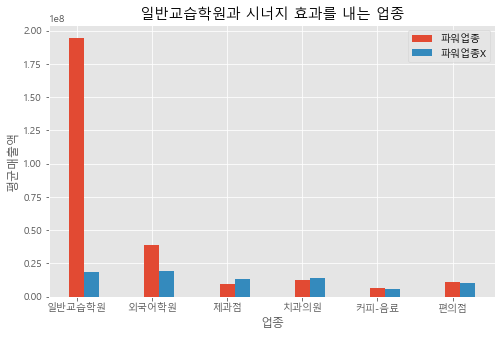

In [113]:
synergy_check(GANGNAM_AMT_2,["일반교습학원","외국어학원","제과점","치과의원","커피-음료","편의점"],cluster1)

### 4) 강남구 의약품

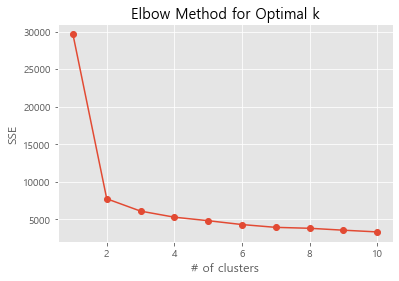

클러스터 개수 k를 입력하세요 : 2


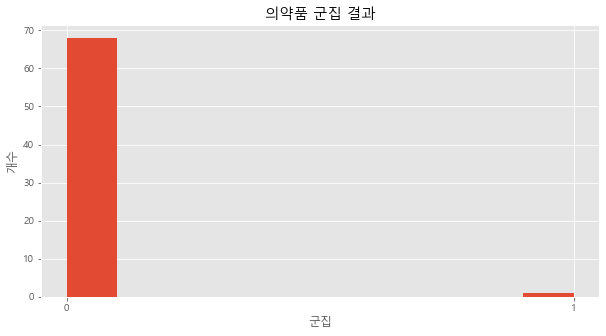

의약품 군집별 블록 개수
0    68
1     1
Name: cluster, dtype: int64


In [99]:
X4 = kmeans(gangnam_train, "의약품")

In [100]:
## 강남구 의약품 0번 군집
cluster0, svc_list = clusterN(X4,0)
synergy_N(cluster0, svc_list)

군집 0 업종의 개수 분포
count    63.000000
mean      0.610177
std       0.627452
min       0.044118
25%       0.235294
50%       0.382353
75%       0.779412
max       3.647059
dtype: float64


,BLCK_CD,미용실,부동산중개업,분식전문점,세무사사무소,슈퍼마켓,일반교습학원,일반의류,일반의원,커피-음료,피부관리실,한식음식점,화장품
944,19579,1.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
945,24412,0.0,1.0,3.0,0.0,1.0,2.0,0.0,2.0,0.0,0.0,1.0,0.0
946,24541,3.0,2.0,1.0,0.0,2.0,1.0,4.0,0.0,3.0,0.0,2.0,3.0
947,28292,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0
948,29886,7.0,4.0,0.0,0.0,0.0,0.0,5.0,1.0,3.0,3.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008,357467,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0
1009,358398,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1010,360652,1.0,4.0,0.0,1.0,0.0,3.0,2.0,2.0,1.0,1.0,3.0,0.0
1011,421394,3.0,3.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,5.0,0.0


업종별 긍정적인 응집도 비율
미용실 18.92
부동산중개업 0
분식전문점 22.58
세무사사무소 100.0
슈퍼마켓 44.44
일반교습학원 33.33
일반의류 20.83
일반의원 10.53
커피-음료 29.55
피부관리실 29.63
한식음식점 26.42
화장품 14.29


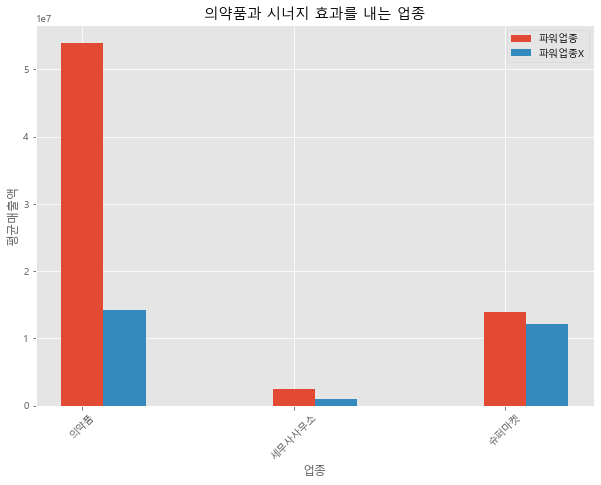

In [101]:
synergy_check(GANGNAM_AMT_2,["의약품","세무사사무소","슈퍼마켓"],cluster0)

In [102]:
cluster0['BLCK_CD'].values

array([ 19579,  24412,  24541,  28292,  29886,  30781,  30783,  31123,
        31166,  32010, 265582, 265915, 267444, 267601, 270770, 273715,
       274614, 275122, 277250, 278232, 278485, 278691, 279623, 279879,
       279882, 353406, 354056, 356803, 364689, 421981,  18071,  24480,
        24561,  24563,  30859,  30921,  30946,  31045,  31067,  31204,
        31244,  31560,  32103,  32909,  33147,  33610, 163441, 198235,
       266233, 267679, 271034, 271766, 271837, 272983, 275734, 278705,
       278874, 279676, 280096, 354489, 355787, 356402, 357373, 357467,
       358398, 360652, 421394, 422411], dtype=int64)

temp = BLCK_DIM.loc[cluster0.index].iloc[:,[0,3,4,5,6,7,8]]
temp.to_csv("C:/Users/bigdata10/Desktop/데이터/블록내 업종간 다이나믹 분석/시각화 데이터/gangnam3_0.csv")

### 5) 강남구 일반의류

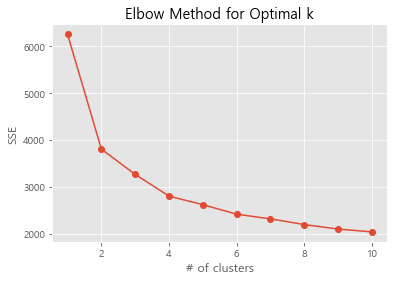

클러스터 개수 k를 입력하세요 : 4


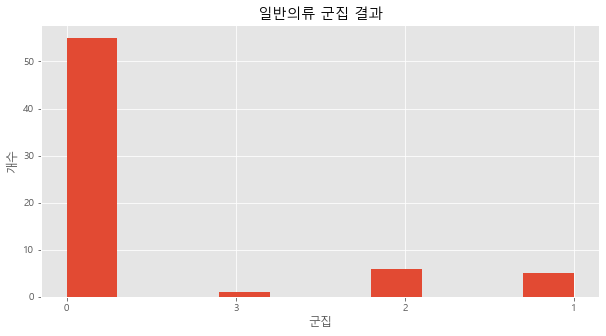

일반의류 군집별 블록 개수
0    55
2     6
1     5
3     1
Name: cluster, dtype: int64


In [103]:
X5 = kmeans(gangnam_train, "일반의류")

In [104]:
## 강남구 일반의류 0번 군집
cluster0, svc_list = clusterN(X5,0)
synergy_N(cluster0, svc_list)

군집 0 업종의 개수 분포
count    63.000000
mean      0.390765
std       0.378253
min       0.018182
25%       0.163636
50%       0.254545
75%       0.472727
max       1.909091
dtype: float64


,BLCK_CD,미용실,부동산중개업,양식음식점,커피-음료,한식음식점,화장품
1222,24389,5.0,0.0,0.0,1.0,2.0,1.0
1223,24421,2.0,2.0,6.0,2.0,1.0,5.0
1224,24444,1.0,0.0,0.0,0.0,1.0,2.0
1225,24561,0.0,3.0,0.0,1.0,5.0,3.0
1226,25891,0.0,0.0,4.0,0.0,0.0,1.0
1227,27842,2.0,1.0,1.0,4.0,0.0,3.0
1228,28432,1.0,1.0,1.0,0.0,0.0,3.0
1229,28934,3.0,0.0,2.0,6.0,5.0,5.0
1230,31470,0.0,3.0,0.0,2.0,1.0,4.0
1231,32769,3.0,1.0,2.0,1.0,0.0,3.0


업종별 긍정적인 응집도 비율
미용실 44.0
부동산중개업 0
양식음식점 34.78
커피-음료 14.29
한식음식점 22.58
화장품 26.92


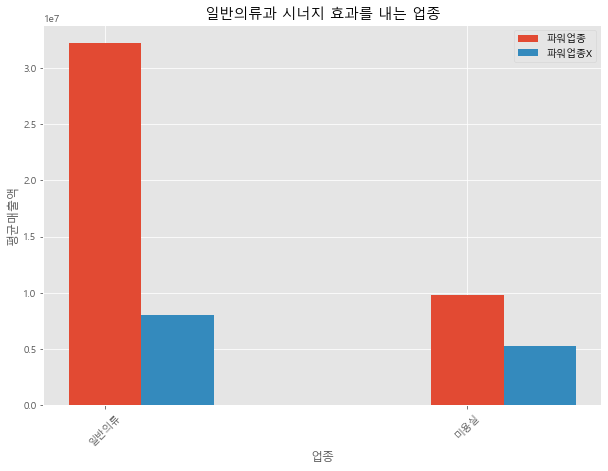

In [105]:
synergy_check(GANGNAM_AMT_2,["일반의류","미용실"],cluster0)

In [106]:
cluster0['BLCK_CD'].values

array([ 24389,  24421,  24444,  24561,  25891,  27842,  28432,  28934,
        31470,  32769,  33653, 264066, 269079, 269169, 269342, 273603,
       305992, 334754, 350521, 353384, 358763, 359065, 360652, 416921,
       419478,  24436,  24443,  24466,  24500,  24503,  28307,  28416,
        28742,  28958,  28970,  30767,  31169,  31214,  33563, 265948,
       267466, 268718, 269036, 269045, 269202, 270211, 270229, 270388,
       275113, 288047, 334668, 349749, 349822, 357893, 359987],
      dtype=int64)

temp = BLCK_DIM.loc[cluster0.index].iloc[:,[0,3,4,5,6,7,8]]
temp.to_csv("C:/Users/bigdata10/Desktop/데이터/블록내 업종간 다이나믹 분석/시각화 데이터/gangnam4_0.csv")

### 6) 강남구 중식음식점

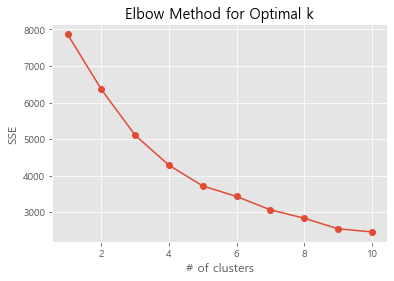

클러스터 개수 k를 입력하세요 : 4


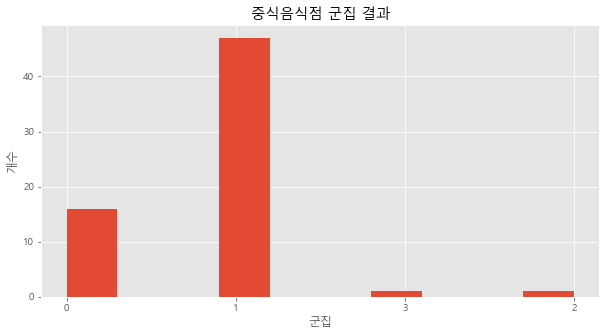

중식음식점 군집별 블록 개수
1    47
0    16
3     1
2     1
Name: cluster, dtype: int64


In [107]:
X6 = kmeans(gangnam_train, "중식음식점")

In [108]:
## 강남구 중식음식점 1번 군집
cluster1, svc_list = clusterN(X6,1)
synergy_N(cluster1, svc_list)

군집 1 업종의 개수 분포
count    63.000000
mean      0.398852
std       0.423295
min       0.021277
25%       0.138298
50%       0.234043
75%       0.510638
max       2.361702
dtype: float64


,BLCK_CD,부동산중개업,분식전문점,일반교습학원,일반의류,커피-음료,한식음식점,화장품
1291,24466,5.0,0.0,0.0,5.0,0.0,2.0,5.0
1292,27005,0.0,2.0,0.0,6.0,5.0,2.0,2.0
1293,27457,0.0,0.0,3.0,1.0,1.0,0.0,2.0
1294,28376,0.0,4.0,2.0,0.0,2.0,1.0,2.0
1296,31178,0.0,0.0,0.0,3.0,1.0,0.0,2.0
1297,31241,1.0,0.0,0.0,1.0,0.0,2.0,0.0
1298,31248,0.0,1.0,0.0,7.0,2.0,3.0,1.0
1299,149893,5.0,0.0,0.0,0.0,2.0,1.0,4.0
1300,151804,0.0,1.0,0.0,1.0,1.0,5.0,0.0
1301,213769,0.0,2.0,0.0,0.0,0.0,7.0,3.0


업종별 긍정적인 응집도 비율
부동산중개업 0
분식전문점 26.32
일반교습학원 18.18
일반의류 0.0
커피-음료 21.74
한식음식점 13.89
화장품 22.22


In [109]:
## 강남구 중식음식점 0번 군집
cluster0, svc_list = clusterN(X6,0)
synergy_N(cluster0, svc_list)

군집 0 업종의 개수 분포
count    63.000000
mean      0.987103
std       1.475444
min       0.062500
25%       0.312500
50%       0.625000
75%       1.000000
max      10.062500
dtype: float64


,BLCK_CD,노래방,미용실,반찬가게,부동산중개업,분식전문점,세무사사무소,스포츠 강습,양식음식점,일반의류,일식음식점,전자상거래업,커피-음료,컴퓨터및주변장치판매,피부관리실,한식음식점,호프-간이주점,화장품
1289,24422,2.0,0.0,1.0,10.0,8.0,0.0,1.0,0.0,3.0,1.0,0.0,1.0,0.0,1.0,4.0,0.0,4.0
1290,24446,0.0,4.0,1.0,5.0,2.0,14.0,2.0,1.0,2.0,2.0,1.0,2.0,0.0,3.0,4.0,1.0,3.0
1295,30460,2.0,2.0,0.0,3.0,1.0,0.0,1.0,1.0,2.0,0.0,5.0,4.0,3.0,3.0,15.0,0.0,3.0
1306,269340,0.0,3.0,1.0,2.0,0.0,0.0,0.0,4.0,4.0,3.0,0.0,1.0,0.0,0.0,7.0,2.0,5.0
1317,354490,4.0,1.0,1.0,5.0,1.0,1.0,1.0,3.0,0.0,3.0,0.0,7.0,2.0,0.0,11.0,1.0,1.0
1320,358634,0.0,5.0,1.0,5.0,4.0,3.0,1.0,4.0,1.0,2.0,2.0,8.0,0.0,3.0,13.0,0.0,3.0
1323,17754,0.0,3.0,7.0,13.0,3.0,2.0,12.0,2.0,9.0,2.0,4.0,6.0,7.0,7.0,8.0,1.0,8.0
1335,32702,0.0,0.0,1.0,2.0,3.0,5.0,0.0,2.0,0.0,0.0,1.0,3.0,1.0,2.0,12.0,0.0,6.0
1336,32731,3.0,2.0,1.0,4.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,2.0,1.0,0.0,9.0,1.0,3.0
1338,265756,1.0,0.0,0.0,3.0,3.0,1.0,0.0,1.0,0.0,1.0,0.0,6.0,1.0,2.0,12.0,3.0,14.0


업종별 긍정적인 응집도 비율
노래방 16.67
미용실 42.86
반찬가게 0.0
부동산중개업 0.0
분식전문점 20.0
세무사사무소 0.0
스포츠 강습 40.0
양식음식점 22.22
일반의류 16.67
일식음식점 42.86
전자상거래업 0.0
커피-음료 33.33
컴퓨터및주변장치판매 50.0
피부관리실 22.22
한식음식점 31.25
호프-간이주점 50.0
화장품 12.5


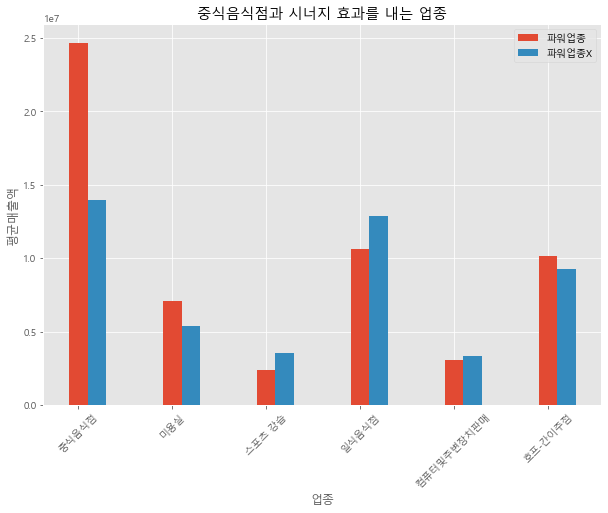

In [110]:
synergy_check(GANGNAM_AMT_2,["중식음식점","미용실","스포츠 강습","일식음식점","컴퓨터및주변장치판매","호프-간이주점"],cluster0)

In [111]:
cluster0['BLCK_CD'].values

array([ 24422,  24446,  30460, 269340, 354490, 358634,  17754,  32702,
        32731, 265756, 274522, 341952, 357419, 358404, 418661, 419866],
      dtype=int64)

temp = BLCK_DIM.loc[cluster0.index].iloc[:,[0,3,4,5,6,7,8]]
temp.to_csv("C:/Users/bigdata10/Desktop/데이터/블록내 업종간 다이나믹 분석/시각화 데이터/gangnam5_0.csv")

### 7) 강남구 양식음식점

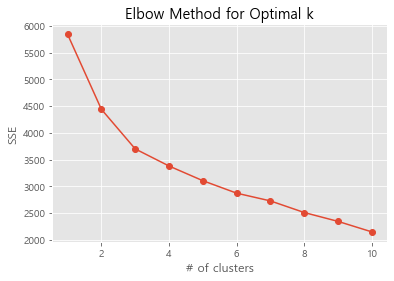

클러스터 개수 k를 입력하세요 : 3


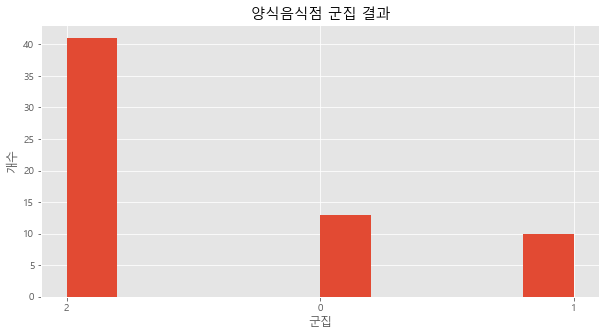

양식음식점 군집별 블록 개수
2    41
0    13
1    10
Name: cluster, dtype: int64


In [112]:
X7 = kmeans(gangnam_train, "양식음식점")

In [113]:
## 강남구 양식음식점 2번 군집
cluster2, svc_list = clusterN(X7,2)
synergy_N(cluster2, svc_list)

군집 2 업종의 개수 분포
count    63.000000
mean      0.339528
std       0.406980
min       0.000000
25%       0.085366
50%       0.195122
75%       0.365854
max       1.707317
dtype: float64


,BLCK_CD,미용실,분식전문점,일반의류,커피-음료,한식음식점,화장품
1088,21487,0.0,2.0,1.0,2.0,0.0,0.0
1089,24503,0.0,0.0,2.0,0.0,0.0,0.0
1090,25491,0.0,2.0,1.0,1.0,1.0,3.0
1092,28903,0.0,2.0,1.0,0.0,0.0,1.0
1093,31233,0.0,0.0,0.0,0.0,1.0,0.0
1095,32637,3.0,1.0,3.0,2.0,2.0,2.0
1096,33163,2.0,6.0,3.0,0.0,2.0,1.0
1097,33631,0.0,1.0,1.0,1.0,2.0,0.0
1098,33652,1.0,3.0,0.0,1.0,0.0,1.0
1101,185292,1.0,0.0,0.0,0.0,5.0,3.0


업종별 긍정적인 응집도 비율
미용실 40.0
분식전문점 45.0
일반의류 23.53
커피-음료 47.06
한식음식점 28.0
화장품 14.29


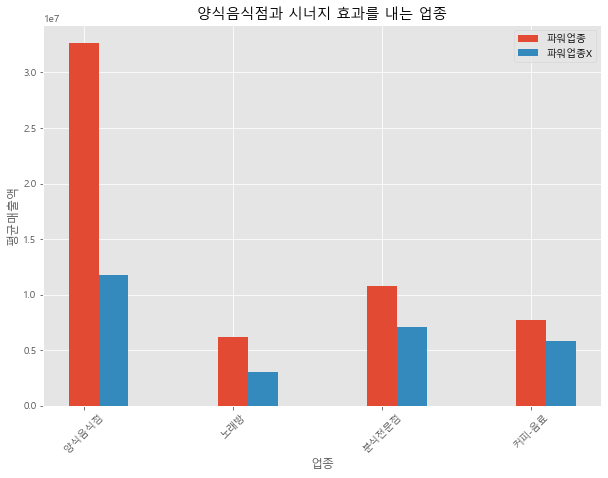

In [114]:
synergy_check(GANGNAM_AMT_2,["양식음식점","노래방","분식전문점","커피-음료"],cluster2)

In [115]:
cluster2['BLCK_CD'].values

array([ 21487,  24503,  25491,  28903,  31233,  32637,  33163,  33631,
        33652, 185292, 268277, 269025, 269036, 269127, 275884, 354016,
       354327, 420271,   4906,  20271,  24423,  24433,  24470,  24564,
        25376,  27271,  28431,  31168,  31435,  31471,  32985,  33677,
       186654, 267484, 269037, 269079, 269162, 270838, 350521, 354853,
       422409], dtype=int64)

temp = BLCK_DIM.loc[cluster2.index].iloc[:,[0,3,4,5,6,7,8]]
temp.to_csv("C:/Users/bigdata10/Desktop/데이터/블록내 업종간 다이나믹 분석/시각화 데이터/gangnam6_2.csv")

In [51]:
## 강남구 양식음식점 1번 군집
cluster1, svc_list = clusterN(X7,1)
synergy_N(cluster1, svc_list)

군집 1 업종의 개수 분포
count    63.000000
mean      0.876190
std       1.833005
min       0.000000
25%       0.200000
50%       0.400000
75%       0.800000
max      13.700000
dtype: float64


,BLCK_CD,노래방,미용실,부동산중개업,분식전문점,일반의류,일반의원,일식음식점,커피-음료,패스트푸드점,피부관리실,한식음식점,호프-간이주점,화장품
1111,357596,3.0,1.0,1.0,1.0,3.0,0.0,3.0,2.0,3.0,0.0,10.0,2.0,3.0
1115,23055,6.0,4.0,4.0,1.0,6.0,6.0,0.0,2.0,0.0,2.0,16.0,9.0,4.0
1119,24549,0.0,6.0,0.0,4.0,0.0,0.0,7.0,8.0,0.0,7.0,12.0,0.0,3.0
1127,30971,0.0,3.0,3.0,4.0,0.0,3.0,0.0,1.0,0.0,0.0,12.0,0.0,1.0
1135,33216,1.0,1.0,1.0,1.0,4.0,13.0,1.0,5.0,2.0,0.0,8.0,0.0,5.0
1143,270698,2.0,1.0,1.0,1.0,2.0,0.0,3.0,3.0,0.0,0.0,12.0,2.0,1.0
1144,270720,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,11.0,2.0,2.0
1146,275602,2.0,0.0,0.0,0.0,1.0,0.0,2.0,9.0,3.0,0.0,24.0,0.0,0.0
1148,353782,1.0,3.0,2.0,3.0,1.0,0.0,4.0,5.0,1.0,9.0,19.0,6.0,4.0
1149,354401,2.0,4.0,1.0,4.0,0.0,0.0,4.0,3.0,2.0,1.0,13.0,6.0,1.0


업종별 긍정적인 응집도 비율
노래방 50.0
미용실 42.86
부동산중개업 0
분식전문점 50.0
일반의류 25.0
일반의원 66.67
일식음식점 57.14
커피-음료 44.44
패스트푸드점 75.0
피부관리실 25.0
한식음식점 90.0
호프-간이주점 83.33
화장품 0.0


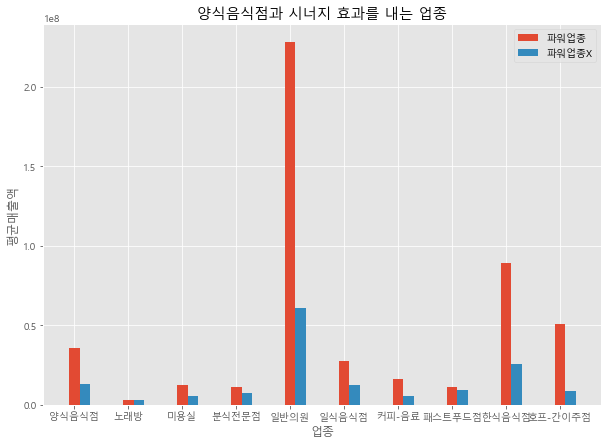

In [55]:
synergy_check(GANGNAM_AMT_2,["양식음식점","노래방","미용실","분식전문점","일반의원","일식음식점","커피-음료","패스트푸드점","한식음식점","호프-간이주점"],cluster1)

temp = BLCK_DIM.loc[cluster1.index].iloc[:,[0,3,4,5,6,7,8]]
temp.to_csv("C:/Users/bigdata10/Desktop/데이터/블록내 업종간 다이나믹 분석/시각화 데이터/gangnam6_1.csv")

In [116]:
## 강남구 양식음식점 0번 군집
cluster0, svc_list = clusterN(X7,0)
synergy_N(cluster0, svc_list)

군집 0 업종의 개수 분포
count    63.000000
mean      0.654457
std       1.319670
min       0.000000
25%       0.076923
50%       0.230769
75%       0.692308
max       9.384615
dtype: float64


,BLCK_CD,미용실,부동산중개업,분식전문점,사진관,일반의류,일반의원,일식음식점,전자상거래업,커피-음료,피부관리실,한식음식점,호프-간이주점,화장품
1091,28307,0.0,1.0,2.0,1.0,7.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1094,32568,0.0,2.0,5.0,1.0,8.0,0.0,1.0,1.0,2.0,2.0,7.0,2.0,1.0
1099,33672,3.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1100,33676,2.0,0.0,1.0,3.0,8.0,0.0,2.0,2.0,0.0,0.0,2.0,2.0,3.0
1106,269157,4.0,2.0,3.0,2.0,6.0,2.0,1.0,1.0,2.0,5.0,3.0,3.0,6.0
1108,283724,3.0,3.0,3.0,1.0,8.0,1.0,2.0,1.0,3.0,2.0,4.0,3.0,1.0
1122,25891,0.0,0.0,2.0,0.0,9.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0
1123,26949,2.0,1.0,3.0,0.0,7.0,2.0,4.0,1.0,6.0,5.0,1.0,0.0,2.0
1125,27842,2.0,1.0,0.0,0.0,6.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,3.0
1131,32970,3.0,2.0,2.0,0.0,12.0,3.0,3.0,2.0,4.0,3.0,5.0,0.0,4.0


업종별 긍정적인 응집도 비율
미용실 60.0
부동산중개업 0
분식전문점 40.0
사진관 50.0
일반의류 61.54
일반의원 20.0
일식음식점 50.0
전자상거래업 0.0
커피-음료 22.22
피부관리실 22.22
한식음식점 55.56
호프-간이주점 16.67
화장품 14.29


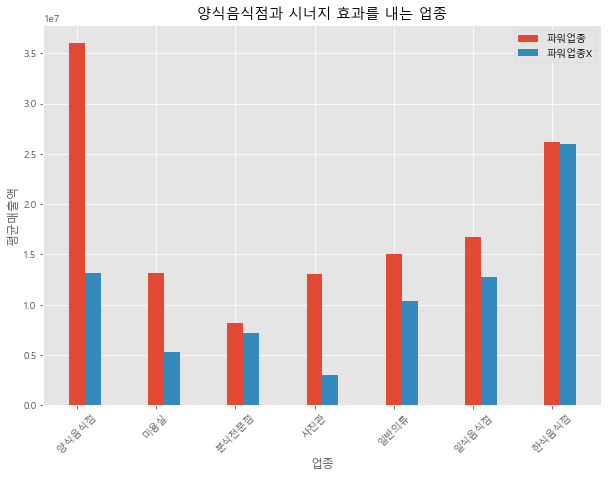

In [117]:
synergy_check(GANGNAM_AMT_2,["양식음식점","미용실","분식전문점","사진관","일반의류","일식음식점","한식음식점"],cluster0)

In [118]:
cluster0['BLCK_CD'].values

array([ 28307,  32568,  33672,  33676, 269157, 283724,  25891,  26949,
        27842,  32970,  33072,  33154,  33632], dtype=int64)

In [58]:
temp = BLCK_DIM.loc[cluster0.index].iloc[:,[0,3,4,5,6,7,8]]
temp.to_csv("C:/Users/bigdata10/Desktop/데이터/블록내 업종간 다이나믹 분석/시각화 데이터/gangnam6_0.csv")

### 8) 강남구 치과의원

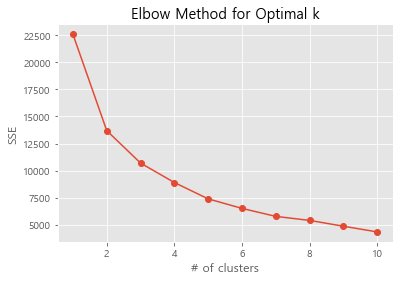

클러스터 개수 k를 입력하세요 : 4


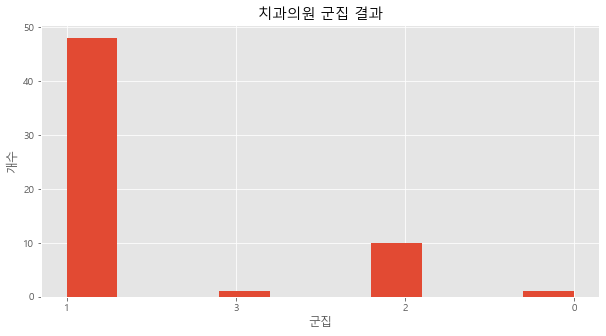

치과의원 군집별 블록 개수
1    48
2    10
3     1
0     1
Name: cluster, dtype: int64


In [119]:
X8 = kmeans(gangnam_train, "치과의원")

In [120]:
## 강남구 치과의원 2번 군집
cluster2, svc_list = clusterN(X8,2)
synergy_N(cluster2, svc_list)

군집 2 업종의 개수 분포
count    63.000000
mean      1.582540
std       2.161805
min       0.000000
25%       0.400000
50%       0.800000
75%       1.800000
max      11.200000
dtype: float64


,BLCK_CD,미용실,반찬가게,법무사사무소,변리사사무소,변호사사무소,부동산중개업,분식전문점,세무사사무소,슈퍼마켓,...,조명용품,중식음식점,커피-음료,컴퓨터및주변장치판매,편의점,피부관리실,한식음식점,호프-간이주점,화장품,회계사사무소
1781,142098,3.0,7.0,0.0,0.0,0.0,4.0,1.0,2.0,0.0,...,1.0,4.0,3.0,4.0,2.0,3.0,21.0,9.0,5.0,0.0
1787,270716,0.0,1.0,4.0,1.0,5.0,5.0,1.0,9.0,1.0,...,1.0,0.0,4.0,2.0,1.0,0.0,6.0,1.0,5.0,2.0
1791,275453,0.0,0.0,0.0,1.0,0.0,7.0,6.0,1.0,1.0,...,0.0,2.0,10.0,1.0,0.0,1.0,30.0,7.0,1.0,0.0
1796,281000,2.0,8.0,0.0,0.0,0.0,8.0,4.0,1.0,7.0,...,1.0,0.0,2.0,5.0,1.0,0.0,9.0,1.0,10.0,0.0
1799,353361,2.0,1.0,0.0,0.0,0.0,18.0,0.0,6.0,2.0,...,0.0,0.0,5.0,2.0,2.0,1.0,2.0,1.0,24.0,1.0
1801,354017,0.0,3.0,2.0,4.0,1.0,12.0,1.0,0.0,0.0,...,2.0,2.0,5.0,2.0,2.0,1.0,12.0,1.0,6.0,0.0
1803,355764,1.0,1.0,0.0,0.0,1.0,2.0,3.0,7.0,0.0,...,0.0,3.0,3.0,1.0,3.0,2.0,17.0,2.0,3.0,1.0
1804,355895,2.0,6.0,2.0,5.0,17.0,7.0,2.0,18.0,2.0,...,2.0,1.0,0.0,2.0,0.0,0.0,1.0,2.0,33.0,4.0
1806,357595,0.0,2.0,1.0,2.0,6.0,4.0,2.0,5.0,1.0,...,2.0,0.0,3.0,5.0,4.0,2.0,11.0,3.0,7.0,0.0
1808,358243,3.0,2.0,1.0,2.0,2.0,12.0,2.0,9.0,2.0,...,1.0,0.0,2.0,5.0,2.0,0.0,3.0,0.0,6.0,5.0


업종별 긍정적인 응집도 비율
미용실 33.33
반찬가게 0.0
법무사사무소 0.0
변리사사무소 0
변호사사무소 66.67
부동산중개업 0
분식전문점 33.33
세무사사무소 100.0
슈퍼마켓 33.33
스포츠 강습 80.0
여행사 0.0
의약품 20.0
일반교습학원 25.0
일반의류 0.0
일반의원 33.33
일식음식점 0.0
전자상거래업 0.0
제과점 50.0
조명용품 0
중식음식점 33.33
커피-음료 62.5
컴퓨터및주변장치판매 50.0
편의점 62.5
피부관리실 50.0
한식음식점 60.0
호프-간이주점 44.44
화장품 12.5
회계사사무소 0


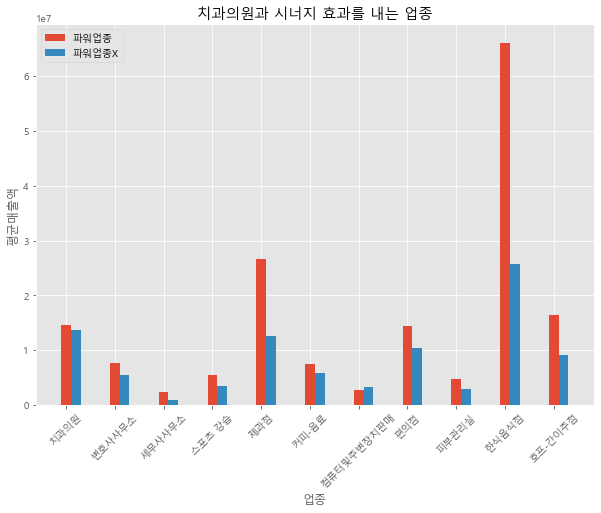

In [121]:
synergy_check(GANGNAM_AMT_2,["치과의원","변호사사무소","세무사사무소","스포츠 강습","제과점","커피-음료",
                             "컴퓨터및주변장치판매","편의점","피부관리실","한식음식점","호프-간이주점"],cluster2)

In [122]:
cluster2['BLCK_CD'].values

array([142098, 270716, 275453, 281000, 353361, 354017, 355764, 355895,
       357595, 358243], dtype=int64)

temp = BLCK_DIM.loc[cluster2.index].iloc[:,[0,3,4,5,6,7,8]]
temp.to_csv("C:/Users/bigdata10/Desktop/데이터/블록내 업종간 다이나믹 분석/시각화 데이터/gangnam7_2.csv")

In [123]:
## 강남구 치과의원 1번 군집
cluster1, svc_list = clusterN(X8,1)
synergy_N(cluster1, svc_list)

군집 1 업종의 개수 분포
count    63.000000
mean      0.605159
std       0.669584
min       0.041667
25%       0.187500
50%       0.375000
75%       0.666667
max       3.104167
dtype: float64


,BLCK_CD,미용실,부동산중개업,분식전문점,양식음식점,외국어학원,의약품,일반교습학원,일반의류,일반의원,커피-음료,한식음식점,화장품
1754,30963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1755,31546,0.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0
1756,31796,5.0,2.0,1.0,3.0,5.0,5.0,7.0,1.0,3.0,2.0,3.0,3.0
1757,32431,2.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,1.0,2.0,3.0
1758,148970,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0
1759,264916,2.0,2.0,2.0,2.0,10.0,0.0,11.0,0.0,0.0,1.0,5.0,1.0
1760,268153,1.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0
1761,268923,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0
1762,274423,0.0,1.0,0.0,0.0,2.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0
1763,288047,4.0,1.0,0.0,1.0,0.0,0.0,0.0,10.0,1.0,0.0,1.0,1.0


업종별 긍정적인 응집도 비율
미용실 22.22
부동산중개업 0
분식전문점 50.0
양식음식점 20.0
외국어학원 20.0
의약품 14.29
일반교습학원 21.43
일반의류 19.23
일반의원 33.33
커피-음료 28.57
한식음식점 36.84
화장품 5.88


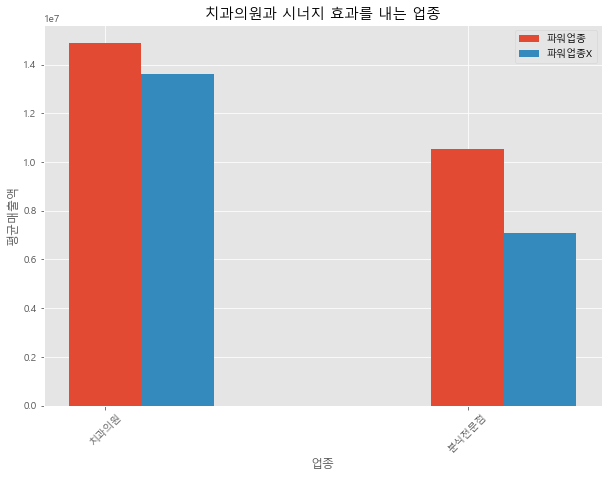

In [124]:
synergy_check(GANGNAM_AMT_2,["치과의원","분식전문점"],cluster1)

In [ ]:
cluster1['BLCK_CD'].values

temp = BLCK_DIM.loc[cluster1.index].iloc[:,[0,3,4,5,6,7,8]]
temp.to_csv("C:/Users/bigdata10/Desktop/데이터/블록내 업종간 다이나믹 분석/시각화 데이터/gangnam7_1.csv")

### 9) 강남구 슈퍼마켓

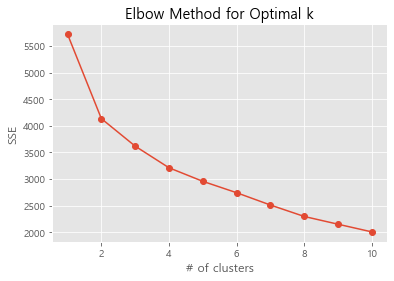

클러스터 개수 k를 입력하세요 : 4


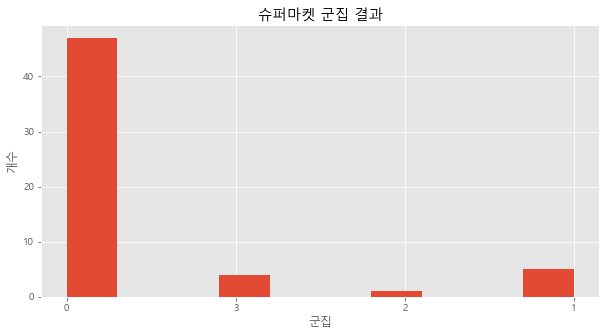

슈퍼마켓 군집별 블록 개수
0    47
1     5
3     4
2     1
Name: cluster, dtype: int64


In [126]:
X9 = kmeans(gangnam_train, "슈퍼마켓")

In [127]:
## 강남구 슈퍼마켓 0번 군집
cluster0, svc_list = clusterN(X9,0)
synergy_N(cluster0, svc_list)

군집 0 업종의 개수 분포
count    63.000000
mean      0.384667
std       0.401088
min       0.021277
25%       0.117021
50%       0.234043
75%       0.500000
max       2.000000
dtype: float64


,BLCK_CD,미용실,부동산중개업,일반의류,커피-음료,한식음식점,화장품
122,4906,1.0,0.0,0.0,0.0,5.0,0.0
123,17944,0.0,0.0,1.0,1.0,1.0,0.0
124,21107,1.0,0.0,0.0,3.0,1.0,1.0
125,21829,1.0,3.0,1.0,1.0,1.0,2.0
126,24577,2.0,3.0,1.0,2.0,1.0,0.0
127,29514,0.0,1.0,1.0,1.0,1.0,1.0
128,30753,8.0,1.0,9.0,1.0,1.0,2.0
129,30946,1.0,0.0,1.0,0.0,5.0,0.0
130,31299,2.0,7.0,4.0,2.0,4.0,0.0
131,32442,1.0,2.0,0.0,2.0,3.0,0.0


업종별 긍정적인 응집도 비율
미용실 18.52
부동산중개업 0
일반의류 0.0
커피-음료 13.79
한식음식점 9.09
화장품 7.69


In [128]:
## 강남구 슈퍼마켓 1번 군집
cluster1, svc_list = clusterN(X9,1)
synergy_N(cluster1, svc_list)

군집 1 업종의 개수 분포
count    63.000000
mean      1.495238
std       1.843159
min       0.000000
25%       0.400000
50%       1.000000
75%       1.800000
max      10.400000
dtype: float64


,BLCK_CD,미용실,반찬가게,부동산중개업,분식전문점,사진관,세탁소,스포츠 강습,안경,양식음식점,...,컴퓨터및주변장치판매,패스트푸드점,편의점,피부관리실,한식음식점,한의원,핸드폰,호프-간이주점,화장품,화초
144,281000,2.0,8.0,8.0,4.0,0.0,1.0,1.0,2.0,0.0,...,5.0,1.0,1.0,0.0,9.0,0.0,1.0,1.0,10.0,3.0
145,281392,4.0,0.0,4.0,4.0,1.0,1.0,3.0,0.0,0.0,...,0.0,3.0,0.0,3.0,10.0,5.0,0.0,6.0,8.0,0.0
158,24424,1.0,0.0,1.0,3.0,1.0,0.0,2.0,2.0,3.0,...,0.0,0.0,0.0,1.0,11.0,1.0,1.0,1.0,9.0,1.0
175,360727,2.0,1.0,6.0,0.0,4.0,2.0,2.0,2.0,3.0,...,6.0,1.0,2.0,2.0,10.0,1.0,2.0,0.0,5.0,0.0
177,420978,10.0,1.0,6.0,13.0,3.0,2.0,1.0,2.0,2.0,...,0.0,3.0,4.0,3.0,12.0,3.0,2.0,1.0,1.0,2.0


업종별 긍정적인 응집도 비율
미용실 50.0
반찬가게 0.0
부동산중개업 0
분식전문점 50.0
사진관 0.0
세탁소 0.0
스포츠 강습 66.67
안경 0.0
양식음식점 0.0
여행사 0
예술학원 0.0
외국어학원 0.0
운동/경기용품 0.0
의약품 0.0
일반교습학원 0.0
일반의류 0.0
일반의원 66.67
일식음식점 0.0
전자상거래업 0
제과점 66.67
치과의원 0.0
커피-음료 20.0
컴퓨터및주변장치판매 0
패스트푸드점 0.0
편의점 66.67
피부관리실 0.0
한식음식점 40.0
한의원 50.0
핸드폰 0.0
호프-간이주점 0.0
화장품 0.0
화초 0.0


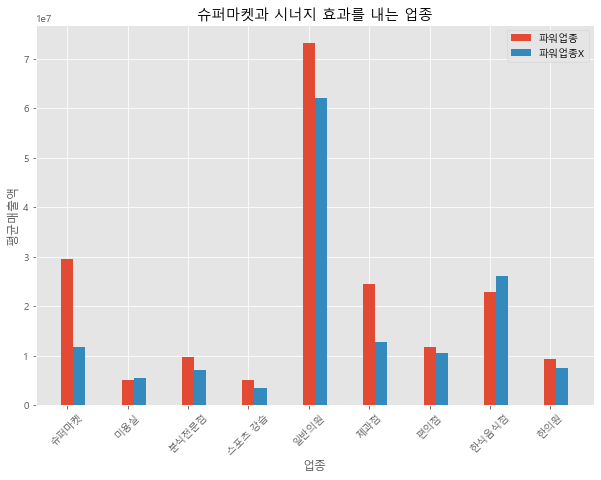

In [129]:
synergy_check(GANGNAM_AMT_2,["슈퍼마켓","미용실","분식전문점","스포츠 강습","일반의원","제과점","편의점","한식음식점","한의원"],cluster1)

In [130]:
cluster1['BLCK_CD'].values

array([281000, 281392,  24424, 360727, 420978], dtype=int64)

temp = BLCK_DIM.loc[cluster1.index].iloc[:,[0,3,4,5,6,7,8]]
temp.to_csv("gangnam8_1.csv")

### 10) 강남구 분식전문점

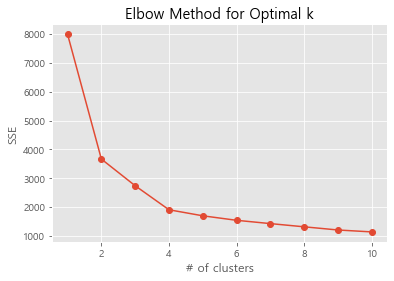

클러스터 개수 k를 입력하세요 : 4


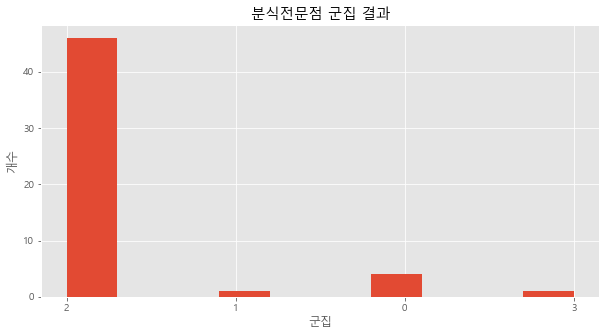

분식전문점 군집별 블록 개수
2    46
0     4
3     1
1     1
Name: cluster, dtype: int64


In [131]:
X10 = kmeans(gangnam_train, "분식전문점")

In [132]:
## 강남구 분식전문점 0번 군집
cluster0, svc_list = clusterN(X10,0)
synergy_N(cluster0, svc_list)

군집 0 업종의 개수 분포
count    63.000000
mean      0.817460
std       2.301913
min       0.000000
25%       0.000000
50%       0.250000
75%       0.750000
max      17.750000
dtype: float64


,BLCK_CD,노래방,문구,변리사사무소,부동산중개업,세무사사무소,스포츠 강습,양식음식점,일반의류,일식음식점,커피-음료,편의점,피부관리실,한식음식점,호프-간이주점
396,265600,2.0,0.0,0.0,1.0,0.0,2.0,3.0,0.0,2.0,1.0,1.0,2.0,14.0,1.0
403,281885,0.0,3.0,4.0,3.0,3.0,1.0,3.0,4.0,1.0,4.0,0.0,1.0,19.0,2.0
404,340742,0.0,2.0,0.0,4.0,1.0,1.0,7.0,2.0,4.0,7.0,3.0,4.0,23.0,2.0
407,353376,2.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,3.0,15.0,3.0


업종별 긍정적인 응집도 비율
노래방 50.0
문구 0
변리사사무소 0
부동산중개업 0
세무사사무소 0
스포츠 강습 0.0
양식음식점 0.0
일반의류 0.0
일식음식점 33.33
커피-음료 0.0
편의점 50.0
피부관리실 33.33
한식음식점 100.0
호프-간이주점 25.0


In [133]:
## 강남구 분식전문점 2번 군집
cluster2, svc_list = clusterN(X10,2)
synergy_N(cluster2, svc_list)

군집 2 업종의 개수 분포
count    63.000000
mean      0.371981
std       0.495945
min       0.021739
25%       0.086957
50%       0.195652
75%       0.369565
max       3.065217
dtype: float64


,BLCK_CD,부동산중개업,일반의류,커피-음료,한식음식점
359,12495,1.0,0.0,1.0,4.0
360,18060,3.0,2.0,1.0,1.0
361,27247,2.0,2.0,0.0,3.0
362,28256,0.0,1.0,0.0,2.0
363,30994,1.0,2.0,1.0,4.0
364,31195,3.0,1.0,5.0,1.0
365,31624,2.0,1.0,2.0,7.0
366,33675,0.0,2.0,0.0,1.0
367,264905,1.0,4.0,0.0,1.0
368,265770,1.0,0.0,0.0,6.0


업종별 긍정적인 응집도 비율
부동산중개업 0
일반의류 20.0
커피-음료 10.0
한식음식점 15.79


# 2. 강북구 군집화

In [137]:
gangbuk_train = gangbuk[["BLCK_CD","SVC_INDUTY_CD_NM"]]
gangbuk_train

,BLCK_CD,SVC_INDUTY_CD_NM
0,169513,한식음식점
1,213447,한식음식점
2,213458,한식음식점
3,213460,한식음식점
4,213464,한식음식점
...,...,...
468,220516,한의원
469,220551,한의원
470,220846,한의원
471,221165,한의원


In [138]:
gangbuk_train = gangbuk_train.merge(BLCK_SVC_CNT, how="left", left_on="BLCK_CD", right_on="BLCK_CD")

In [139]:
# 군집화의 성능 향상을 위해, 컬럼별로 0의 비율 구한 뒤 제거하기
ZERO_RATIO = gangbuk_train.isin([0]).sum()/len(gangbuk_train)*100
ZERO_RATIO = ZERO_RATIO[2:]
ZERO_DROP = list(ZERO_RATIO[ZERO_RATIO.values>ZERO_RATIO.describe()["75%"]].index) #89%
gangbuk_train = gangbuk_train.drop(ZERO_DROP,axis=1)
gangbuk_train #473*73

,BLCK_CD,SVC_INDUTY_CD_NM,PC방,가구,가방,가전제품,가전제품수리,골프연습장,기타법무서비스,기타오락장,...,컴퓨터및주변장치판매,패스트푸드점,편의점,피부관리실,한식음식점,한의원,핸드폰,호프-간이주점,화장품,화초
0,169513,한식음식점,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0
1,213447,한식음식점,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,4.0,0.0,0.0,1.0,0.0,0.0
2,213458,한식음식점,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0
3,213460,한식음식점,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,5.0,0.0,0.0,1.0,0.0,0.0
4,213464,한식음식점,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7.0,0.0,6.0,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,220516,한의원,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,4.0,2.0,0.0,3.0,1.0,0.0
469,220551,한의원,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0
470,220846,한의원,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0
471,221165,한의원,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0


In [140]:
gangbuk_train["SVC_INDUTY_CD_NM"].value_counts()

한식음식점      135
슈퍼마켓        45
편의점         40
일반의원        37
의약품         30
육류판매        26
치과의원        22
호프-간이주점     21
자동차수리       20
미용실         20
치킨전문점       20
일반의류        15
주유소         11
제과점         11
한의원         10
중식음식점       10
Name: SVC_INDUTY_CD_NM, dtype: int64

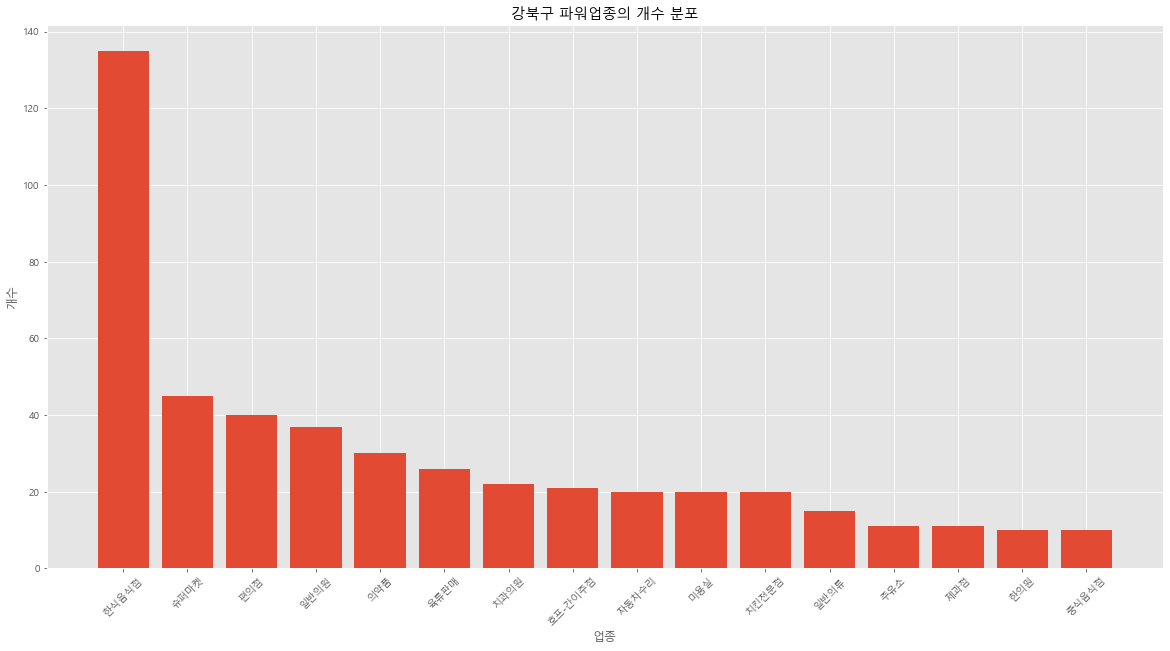

In [141]:
X = gangbuk_train["SVC_INDUTY_CD_NM"].value_counts().index
Y = gangbuk_train["SVC_INDUTY_CD_NM"].value_counts().values
plt.figure(figsize=(20, 10))
plt.bar(X,Y)
plt.xticks(rotation=45)
plt.xlabel("업종")
plt.ylabel("개수")
plt.title("강북구 파워업종의 개수 분포")
plt.show()

In [142]:
GANGBUK_AMT_2= pd.merge(SELNG_DEC_SVC,GANGBUK_CD,on="BLCK_CD").iloc[:,[0,1,2,4,-4,]]
GANGBUK_AMT_2.index = GANGBUK_AMT_2["BLCK_CD"]

### 1) 강북구 한식음식점

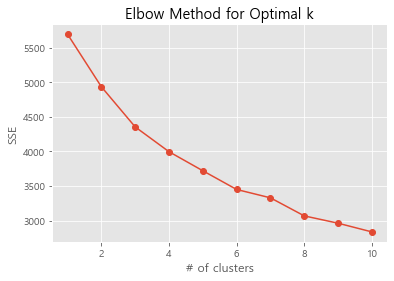

클러스터 개수 k를 입력하세요 : 4


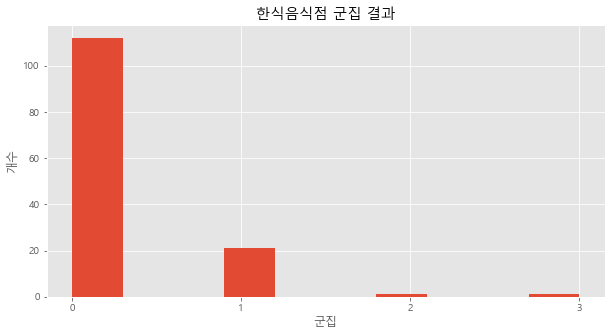

한식음식점 군집별 블록 개수
0    112
1     21
3      1
2      1
Name: cluster, dtype: int64


In [143]:
Y1 = kmeans(gangbuk_train, "한식음식점")

In [144]:
## 강북구 한식음식점 1번 군집
cluster0, svc_list = clusterN(Y1,1)
synergy_B(cluster0, svc_list)

군집 1 업종의 개수 분포
count    75.000000
mean      0.443810
std       0.865615
min       0.000000
25%       0.047619
50%       0.190476
75%       0.428571
max       5.380952
dtype: float64


,BLCK_CD,노래방,부동산중개업,분식전문점,일반의류,커피-음료,호프-간이주점
12,218961,4.0,2.0,1.0,6.0,0.0,2.0
31,219599,2.0,1.0,1.0,1.0,1.0,7.0
36,219875,9.0,1.0,0.0,1.0,0.0,2.0
38,219880,7.0,1.0,1.0,2.0,1.0,3.0
39,219884,14.0,1.0,2.0,1.0,1.0,1.0
40,219888,11.0,0.0,1.0,0.0,0.0,4.0
42,219890,10.0,7.0,2.0,4.0,2.0,3.0
47,220109,1.0,6.0,1.0,4.0,4.0,2.0
48,220117,4.0,1.0,0.0,0.0,1.0,6.0
50,220130,4.0,0.0,6.0,2.0,4.0,16.0


업종별 긍정적인 응집도 비율
노래방 77.78
부동산중개업 0
분식전문점 35.29
일반의류 38.46
커피-음료 58.33
호프-간이주점 61.11


In [145]:
## 강북구 한식음식점 0번 군집
cluster0, svc_list = clusterN(Y1,0)
synergy_B(cluster0, svc_list)

군집 0 업종의 개수 분포
count    75.000000
mean      0.217738
std       0.244192
min       0.000000
25%       0.062500
50%       0.125000
75%       0.254464
max       1.080357
dtype: float64


,BLCK_CD,미용실,부동산중개업,호프-간이주점
0,169513,1.0,0.0,0.0
1,213447,2.0,0.0,1.0
2,213458,0.0,3.0,3.0
3,213460,0.0,0.0,1.0
4,213464,2.0,1.0,2.0
...,...,...,...,...
130,338554,0.0,0.0,1.0
131,338568,2.0,3.0,1.0
132,409567,0.0,0.0,0.0
133,410193,0.0,0.0,2.0


업종별 긍정적인 응집도 비율
미용실 26.87
부동산중개업 0.0
호프-간이주점 17.86


In [146]:
synergy_check(GANGBUK_AMT_2,["한식음식점","노래방","호프-간이주점","커피-음료"],cluster0)

KeyError: 'SVC_INDUTY_CD_NM'

In [147]:
cluster0["BLCK_CD"].values

array([169513, 213447, 213458, 213460, 213464, 213472, 216413, 216432,
       218496, 218659, 218667, 218679, 219007, 219074, 219104, 219252,
       219257, 219260, 219289, 219332, 219368, 219427, 219465, 219514,
       219554, 219556, 219573, 219580, 219604, 219721, 219751, 219846,
       219877, 219889, 219918, 219922, 219933, 220084, 220118, 220149,
       220154, 220158, 220176, 220449, 220450, 220470, 220490, 220497,
       220511, 220513, 220516, 220527, 220546, 220688, 220730, 220797,
       220798, 220821, 220825, 220846, 220877, 220891, 220895, 220910,
       220974, 221019, 221121, 221143, 221149, 221163, 338618, 410942,
       213432, 215851, 215886, 216095, 216117, 218641, 218971, 218991,
       219029, 219031, 219072, 219255, 219329, 219339, 219510, 219576,
       219598, 219740, 219820, 219836, 219883, 219891, 220415, 220420,
       220423, 220427, 220443, 220464, 220581, 220646, 220668, 220707,
       220921, 221078, 221578, 338554, 338568, 409567, 410193, 410798],
     

In [ ]:
## 강북구 한식음식점 2번 군집
cluster2, svc_list = clusterN(Y1,2)
synergy_B(cluster2, svc_list)

In [ ]:
synergy_check(GANGBUK_AMT_2,["한식음식점","미용실","여관","커피-음료","피부관리실"],cluster2)

In [ ]:
cluster2["BLCK_CD"].values

### 2. 강북구 슈퍼마켓

In [ ]:
Y2 = kmeans(gangbuk_train, "슈퍼마켓")

In [ ]:
#강북구 슈퍼마켓 0번째 군집
cluster0, svc_list = clusterN(Y2,0)
synergy_B(cluster0, svc_list)

In [ ]:
#강북구 슈퍼마켓 2번째 군집
cluster2, svc_list = clusterN(Y2,2)
synergy_B(cluster2, svc_list)

In [ ]:
synergy_check(GANGBUK_AMT_2,["슈퍼마켓","미용실","반찬가게","분식전문점","스포츠강습","시계및귀금속","외국어학원","육류판매","의약품","일반교습학원","일반의원","커피-음료","패스트푸드점","피부관리실","한의원"],cluster2,size=(20,10))

In [ ]:
cluster2["BLCK_CD"].values

### 3. 강북구 편의점

In [ ]:
Y3 = kmeans(gangbuk_train, "편의점")

In [ ]:
#강북구 편의점 0번째 군집
cluster0, svc_list = clusterN(Y3,0)
synergy_B(cluster0, svc_list)

### 4. 강북구 일반의원

In [ ]:
Y4 = kmeans(gangbuk_train,"일반의원")

In [ ]:
#강북구 일반의원 2번째 군집
cluster2, svc_list = clusterN(Y4,2)
synergy_B(cluster2, svc_list)

In [ ]:
#강북구 일반의원 0번째 군집
cluster0, svc_list = clusterN(Y4,0)
synergy_B(cluster0, svc_list)

In [ ]:
synergy_check(GANGBUK_AMT_2,["일반의원","미용실","의약품","일반의류","한식음식점"],cluster0)

In [ ]:
cluster0["BLCK_CD"].values

### 5. 호프-간이주점

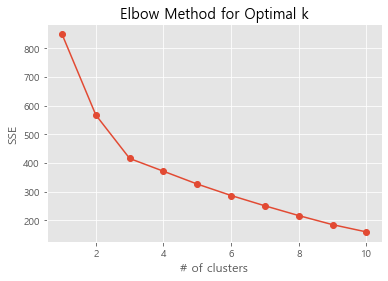

클러스터 개수 k를 입력하세요 : 4


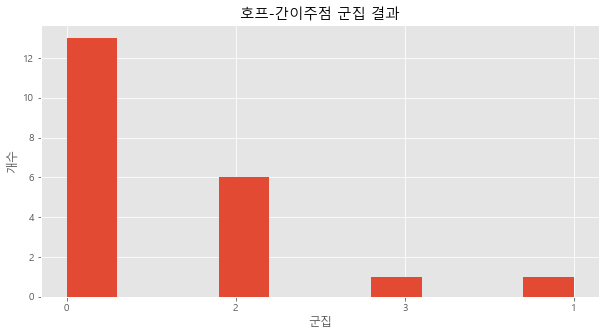

호프-간이주점 군집별 블록 개수
0    13
2     6
3     1
1     1
Name: cluster, dtype: int64


In [154]:
Y5 = kmeans(gangbuk_train, "호프-간이주점")

In [155]:
#강북구 호프-간이주점 0번째 군집
cluster0, svc_list = clusterN(Y5,0)
synergy_B(cluster0, svc_list)

군집 0 업종의 개수 분포
count    75.000000
mean      0.212308
std       0.264312
min       0.000000
25%       0.076923
50%       0.153846
75%       0.307692
max       1.307692
dtype: float64


,BLCK_CD,미용실,분식전문점,한식음식점
380,216423,1.0,0.0,0.0
381,218963,1.0,0.0,1.0
383,219740,1.0,0.0,1.0
386,220501,1.0,2.0,3.0
387,220913,2.0,1.0,0.0
388,216049,0.0,2.0,0.0
389,216359,1.0,2.0,2.0
390,216432,2.0,1.0,2.0
391,219257,3.0,0.0,1.0
392,219304,0.0,2.0,2.0


업종별 긍정적인 응집도 비율
미용실 11.11
분식전문점 12.5
한식음식점 12.5


In [156]:
#강북구 호프-간이주점 2번째 군집
cluster2, svc_list = clusterN(Y5,2)
synergy_B(cluster2, svc_list)

군집 2 업종의 개수 분포
count    75.000000
mean      0.308889
std       0.881361
min       0.000000
25%       0.000000
50%       0.000000
75%       0.333333
max       7.166667
dtype: float64


,BLCK_CD,노래방,미용실,슈퍼마켓,여관,커피-음료,편의점,한식음식점
382,219585,1.0,2.0,3.0,1.0,1.0,0.0,6.0
384,220055,3.0,0.0,1.0,0.0,1.0,4.0,6.0
394,220117,4.0,2.0,0.0,0.0,1.0,0.0,10.0
397,220713,3.0,0.0,0.0,0.0,2.0,1.0,6.0
398,220727,0.0,1.0,1.0,5.0,0.0,1.0,9.0
399,220825,0.0,1.0,1.0,0.0,2.0,0.0,6.0


업종별 긍정적인 응집도 비율
노래방 50.0
미용실 25.0
슈퍼마켓 0.0
여관 50.0
커피-음료 40.0
편의점 100.0
한식음식점 83.33


In [157]:
synergy_check(GANGBUK_AMT_2,["호프-간이주점","노래방","분식전문점","편의점","한식음식점"],cluster2)

KeyError: 'SVC_INDUTY_CD_NM'

In [153]:
cluster2["BLCK_CD"].values

array([220131], dtype=int64)

### 6. 강북구 미용실

In [ ]:
Y6 = kmeans(gangbuk_train,"미용실")

In [ ]:
#강북구 미용실 3번째 군집
cluster3, svc_list = clusterN(Y6,3)
synergy_B(cluster3, svc_list)

In [ ]:
#강북구 미용실 0번째 군집
cluster0, svc_list = clusterN(Y6,0)
synergy_B(cluster0, svc_list)

In [ ]:
synergy_check(GANGBUK_AMT_2,["미용실","여관","치킨전문점"],cluster0)

In [ ]:
cluster0["BLCK_CD"].values

### 7. 강북구 치킨전문점

In [ ]:
Y7 = kmeans(gangbuk_train, "치킨전문점")

In [ ]:
#강북구 치킨전문점 0번째 군집
cluster0, svc_list = clusterN(Y7,0)
synergy_B(cluster0, svc_list)

In [ ]:
#강북구 치킨전문점 2번째 군집
cluster2, svc_list = clusterN(Y7,2)
synergy_B(cluster2, svc_list)

### 8. 강북구 의약품

In [ ]:
Y8 = kmeans(gangbuk_train, "의약품")

In [ ]:
#강북구 의약품 2번째 군집
cluster2, svc_list = clusterN(Y8,2)
synergy_B(cluster2, svc_list)

In [ ]:
#강북구 의약품 3번째 군집
cluster3, svc_list = clusterN(Y8,3)
synergy_B(cluster3, svc_list)

In [ ]:
synergy_check(GANGBUK_AMT_2,["의약품","노래방","치킨전문점","한식음식점"],cluster3)

In [ ]:
cluster3["BLCK_CD"].values